# Descriptive fit analysis

Last access (y.m.d): 20.03.23  
Last update (y.m.d): 20.03.23   

In this notebook, I gather all V1 cells (data, model, descriptive fits) and analyze based on this complete set.

### Table of contents

- Initialize  
- Gather  
- Distribution of tuning measures  
  - model free measures  
  - comparison with derived measures  
  - comparison with Cavanuagh, other datasets  
- Simple vs complex  
- Tuning shifts  
  - Preferred spatial frequency with contrast 
  - Center of mass with contrast 
  - SFBW with contrast 
  - sfVariance with contrast 
  - Trajectories of these metrics across contrasts  
- Preferred spatial frequency with contrast *and* dispersion  
  - Histograms/trajectories of metrics with dispersion, split by contrast  
  - Median tuning measure shift across dispersion, plotted across all contrasts (together)  
     - sfCom and pSf  
     - sfCom and sfComCut (see figure for explanation)  
  - Contrast shifts across dispersion  
  - Plot shift distributions at each dispersion  

## Initialize

In [1]:
import pandas as pd
import pdb
import warnings
warnings.filterwarnings(action='once')

In [2]:
import numpy as np
import os
import helper_fcns as hf
# import model_responses as mr
import scipy.stats as ss
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
# plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

# expDirs (and expNames must always be of the right length, i.e. specify for each expt dir 
## V1 version
expDirs = ['V1_orig/', 'altExp/', 'V1/']
expNames = ['dataList.npy', 'dataList.npy', 'dataList_glx.npy']

nExpts = len(expDirs);

# these are usually same for all expts...we'll "tile" below
# fitBase = 'fitList_190502cA';
fitBase = 'fitList_191023c';
fitNamesWght = ['%s_wght_chiSq.npy' % fitBase];
fitNamesFlat = ['%s_flat_chiSq.npy' % fitBase];
####
# descrFits - loss type determined by comparison (choose best; see modCompare.ipynb::Descriptive Fits)
####
dogNames = ['descrFits_190503_poiss_sach.npy', 'descrFits_190503_poiss_sach.npy', 'descrFits_191023_sach_sach.npy'];
descrMod = 0; # which model for the diff. of gauss fits (0/1/2: flex/sach/tony)
descrNames = ['descrFits_190503_sqrt_flex.npy', 'descrFits_190503_sqrt_flex.npy', 'descrFits_191023_sqrt_flex.npy'];

rvcNames = ['rvcFits_f0.npy', 'rvcFits_f0.npy', 'rvcFits_191023_NR_pos.npy'];
# rvcNames   = ['rvcFits_f0.npy'];
# pack to easily tile
expt = [expDirs, expNames, fitNamesWght, fitNamesFlat, descrNames, dogNames, rvcNames];
for exp_i in range(len(expt)):
    if len(expt[exp_i]) == 1:
        expt[exp_i] = expt[exp_i] * nExpts;
# now unpack for use
expDirs, expNames, fitNamesWght, fitNamesFlat, descrNames, dogNames, rvcNames = expt;

base_dir = os.getcwd() + '/';

saveName = 'figures/reports/descrAnalysis_200316_V1/' # for one save name for all figures
save_loc = base_dir + saveName;

/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from _

In [3]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

## Gather data

Now, let's create a large list which will combine data/fits/analyses from all cells for all of the above experiments. For each cell, let's keep track of:
* "meta" parameters:
    * which experiment directory
    * which dataList, fitList, descrFit, rvcFit
    * which cell number within those lists
    * which experiment index?
    * which stimulus values (i.e. dispersions, sfs, contrasts)
* inferred parameters:
    * prefSf (for all conditions), along with % var explained
    * c50 (again, for all conditions)
* model parameters
    * fit parameters, loss value for weighted and flat

In [579]:
# jointList_og = jointList; # we saved - as jointList_og - jl with rvcFits_f0.npy for all rvcFits

In [580]:
# what do we want to track for each cell?
jointList = []; # we'll pack dictionaries in a list...

#### these are now defaults in hf.jl_create - but here, nonetheless, for reference!

# any parameters we need for analysis below?
varExplThresh = 75; # i.e. only include if the fit explains >X (e.g. 75)% variance
dog_varExplThresh = 60; # i.e. only include if the fit explains >X (e.g. 75)% variance

sf_range = [0.01, 10]; # allowed values of 'mu' for fits - see descr_fit.py for details

conDig = 1; # i.e. round to nearest tenth (1 decimal place)
rawInd = 0; # for accessing ratios/differences that we pass into diffsAtThirdCon

muLoc = 2; # mu is in location '2' of parameter arrays
c50Loc = 2; # c50 is in location 2 of parameter arrays

In [581]:
# NOTE: the real code for creating the jointList has been moved to helper_fcns!
# WARNING: This takes [~/<]10 minutes (as of 09.06.19)
jointList = hf.jl_create(base_dir, expDirs, expNames, fitNamesWght, fitNamesFlat, descrNames, dogNames, rvcNames)

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:544: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  binEdges = numpy.linspace(0, stimDur, 1+stimDur/binWidth);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2708: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1334: RuntimeWarning: invalid value encountered in greater
  validInds = np.where(descrFit['varExpl'][disp, :] > varThresh)[0];
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2746: UserWarning: This experiment type (expInd=3) usually has associated RVC fits for response adjustment
  warnings.warn('This experiment type (expInd=3) usually has associated RVC fits for response adjustment');
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2125: DeprecationWarning: The truth value

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2746: UserWarning: This experiment type (expInd=3) usually has associated RVC fits for response adjustment
  warnings.warn('This experiment type (expInd=3) usually has associated RVC fits for response adjustment');
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2746: UserWarning: This experiment type (expInd=3) usually has associated RVC fits for response adjustment
  warnings.warn('This experiment type (expInd=3) usually has associated RVC fits for response adjustment');
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2746: UserWarning: This experiment type (expInd=3) usually has associated RVC fits for response adjustment
  warnings.warn('This experiment type (expInd=3) usually has associated RVC fits for response adjustment');
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2746: UserWarning: This experiment type (expInd=3) usually 

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2746: UserWarning: This experiment type (expInd=3) usually has associated RVC fits for response adjustment
  warnings.warn('This experiment type (expInd=3) usually has associated RVC fits for response adjustment');


In [582]:
from datetime import datetime
suffix = datetime.today().strftime('%y%m%d')

np.save(base_dir + 'jointList_%s' % suffix, jointList)

## Difference of gaussian analysis

quickly added on 19.11.22

In [15]:
nCells = len(jointList);

allDisps = []; allCons = []; allSfs = []; allConByDisp =[]; #allSfRef = [];

for cellNum in range(nCells):
        
    curr_meta = jointList[cellNum]['metadata'];
        
    allDisps.append(curr_meta['stimVals'][0])
    allCons.append(curr_meta['stimVals'][1])
    allSfs.append(curr_meta['stimVals'][2])
    allConByDisp.append(curr_meta['val_con_by_disp']);
#     # let's also save high contrast, single grating SF tuning
#     allSfRef.append(sfRef);

WORK ON THIS

In [ ]:
all_params = [descrFits[x]['params'][0] for x in val_cells]
flat_params = np.asarray(hf.flatten_list(all_params))
all_varExpl = [descrFits[x]['varExpl'][0] for x in val_cells]
flat_varExpl = np.asarray(hf.flatten_list(all_varExpl));
all_prefSf = [descrFits[x]['prefSf'][0] for x in val_cells]
flat_prefSf = np.asarray(hf.flatten_list(all_varExpl));
all_NLL = [descrFits[x]['NLL'][0] for x in val_cells]
flat_NLL = np.asarray(hf.flatten_list(all_NLL));

n_cells = len(all_params);
n_cons = np.array([len(allConByDisp[x][0]) for x in val_cells])
max_nCons = np.max(n_cons)

## Distribution of tuning measures

Here, let's look at the distribution of preferred spatial frequencies and bandwidths in the population.

Suppose we are looking at the preferred spatial frequency measure. Located within metrics, the measure is organized by dispersion (low to high), and within that, by contrast (again, low to high). Thus, jointList[x]['metrics']['pSf'][0][6] would have the preferred spatial frequency zero dispersion, 6th highest (0-indexed) contrast. Thus, to get the highest contrast, we index "-1" for the contrast (single gratings, only, since with newer versions of the experiment, the total contrast values of different dispersions differ slightly, and therefore occupy different locations in the list of total contrasts).

#### Model-free measures

First, let's look at model-free measures of the spatial frequency tuning curve.

In [ ]:
disp = 0;
con = -1; # highest for single gratings
comHighCon = np.array([jointList[i]['metrics']['sfCom'][disp][con] for i in range(len(jointList))])
comCutHighCon = np.array([jointList[i]['metrics']['sfComCut'][disp][con] for i in range(len(jointList))])
varHighCon = np.array([jointList[i]['metrics']['sfVar'][disp][con] for i in range(len(jointList))])

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

#######
# central tendency
#######
bins = np.linspace(-1.5, 2.5, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
coms_clipped = np.clip(hf.nan_rm(np.log2(comHighCon)), clipLow, clipHigh);
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nSF = len(coms_clipped);
medianSF = np.nanmedian(comHighCon);
mnSF = np.nanmean(comHighCon);
gmnSF = gmean(hf.nan_rm(comHighCon));

# plot
vals, _ = np.histogram(coms_clipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[0].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
ax[0].set_xticks(tickVals);
ax[0].set_xticklabels(tickStrs, rotation=45);
sns.despine(ax=ax[0], offset=5)

ax[0].set_xlabel('center of mass sf (cpd)')
ax[0].set_ylabel('fraction of cells')
ax[0].set_title('frequency c.o.m. (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (nSF, medianSF, mnSF, gmnSF));


#######
# variance
#######
bins = np.linspace(0.25, 1.75, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
vars_clipped = np.clip(hf.nan_rm(varHighCon), clipLow, clipHigh);
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nSF = len(vars_clipped);
medianSF = np.nanmedian(varHighCon);
mnSF = np.nanmean(varHighCon);
gmnSF = gmean(hf.nan_rm(varHighCon));

# plot
vals, _ = np.histogram(vars_clipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[1].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(ax=ax[1], offset=5)
tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
ax[1].set_xticks(tickVals);
ax[1].set_xticklabels(tickStrs);

ax[1].set_xlabel('variance of tuning (a.u.)');
ax[1].set_ylabel('fraction of cells');
ax[1].set_title('variance (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (nSF, medianSF, mnSF, gmnSF));


Now, let's go to derived measures - i.e. measures of the tuning curve that rely on descriptive tuning functions

In [ ]:
disp = 0;
con = -1; # highest for single gratings
pSfHighCon = np.array([jointList[i]['metrics']['pSf'][disp][con] for i in range(len(jointList))])
bwHalfHighCon = np.array([jointList[i]['metrics']['bwHalf'][disp][con] for i in range(len(jointList))])
bw34HighCon = np.array([jointList[i]['metrics']['bw34'][disp][con] for i in range(len(jointList))])

dog_pSfHighCon = np.array([jointList[i]['metrics']['dog_pSf'][disp][con] for i in range(len(jointList))])
dog_charFreqHighCon = np.array([jointList[i]['metrics']['dog_charFreq'][disp][con] for i in range(len(jointList))])

#### Compare model-free and derived measures

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

# central tendency
ax[0].loglog(comHighCon, pSfHighCon, 'o', c='k');
mn, mx = np.minimum(np.nanmin(comHighCon), np.nanmin(pSfHighCon)), np.maximum(np.nanmax(comHighCon), np.nanmax(pSfHighCon))
ax[0].loglog([mn, mx], [mn, mx], 'k--');
ax[0].set_xlabel('center of mass sf (cpd)')
ax[0].set_ylabel('peak sf (cpd)')
non_nan = np.logical_and(~np.isnan(comHighCon), ~np.isnan(pSfHighCon))
slope, intercept, r, p, err = linregress(comHighCon[non_nan], pSfHighCon[non_nan])
# slope, intercept, r, p, err = linregress(np.log(comHighCon[non_nan]), np.log(pSfHighCon[non_nan]))
plt_vals = np.geomspace(mn, mx, 50);
ax[0].loglog(plt_vals, intercept + plt_vals*slope, 'r-', label='m=%.2f, r=%.2f (p=%.1e)' % (slope, r, p))
ax[0].legend(fontsize='small');
sns.despine(ax=ax[0], offset=5)

# variance
ax[1].loglog(varHighCon, bwHalfHighCon, 'o', c='k');
mn, mx = np.minimum(np.nanmin(varHighCon), np.nanmin(bwHalfHighCon)), np.maximum(np.nanmax(varHighCon), np.nanmax(bwHalfHighCon))
ax[1].loglog([mn, mx], [mn, mx], 'k--');
ax[1].set_xlabel('variance measure')
ax[1].set_ylabel('bandwidth at half-height (oct)')
non_nan = np.logical_and(~np.isnan(varHighCon), ~np.isnan(bwHalfHighCon))
slope, intercept, r, p, err = linregress(varHighCon[non_nan], bwHalfHighCon[non_nan])
# slope, intercept, r, p, err = linregress(np.log(varHighCon[non_nan]), np.log(bwHalfHighCon[non_nan]))
plt_vals = np.geomspace(mn, mx, 50);
ax[1].loglog(plt_vals, intercept + plt_vals*slope, 'r-', label='m=%.2f, r=%.2f (p=%.1e)' % (slope, r, p))
ax[1].legend(fontsize='small');
sns.despine(ax=ax[1], offset=5)

In [ ]:
bins = np.linspace(-2.5, 3.5, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [comHighCon, pSfHighCon];
fitStr = ['c.o.m.', 'pSf']

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(15, 2*10))
# ax.set(xscale="log")

for i in range(2):

    plt.subplot(2,1,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.xlabel('spatial frequency (c/deg)');
    plt.title('Distribution of frequency preference [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSF[i], medianSF[i], mnSF[i], gmnSF[i]));


#### Cavanaugh dataset
Now, let's load the Cavanaugh (?) dataset sent to me by Tony

In [6]:
cv_file = 'v1-jrc-cavanaugh.xls'
df = pd.read_excel(cv_file);

In [7]:
# What are the columns?
df.keys()

Index(['Casename', 'AREA', 'PEN     ', 'HEMI    ', 'DEPTH   ', 'LAYER   ',
       'SCRDIST ', 'pixpercm', 'qual-OD      ', 'qual-rsp', 'qual-ISOL    ',
       'qual-rfx', 'qual-rfy', 'rfeccen', 'qual-rfsz', 'complexity',
       'class(s1,c0)', 'prefori', 'direct', 'oriwid', 'vectprefori',
       'vectprefdir', 'vectoribias', 'vectdirbias', 'optsf', 'sfwid', 'sfqual',
       'opttf', 'tfwid', 'tfqual', 'dataoptszdg', 'fitoptszdg', 'dsuprsp',
       'datasuppidx', 'fitsuppidx'],
      dtype='object')

In [8]:
### what do we want to get
# first, get the restricted set
eccBounds = [2, 6]
ecc_match = np.logical_and(df['rfeccen']>eccBounds[0], df['rfeccen']<eccBounds[1])
ecc_inds = np.where(ecc_match)[0]

# pref Sf
cav_psf = df['optsf'];
cav_psfEcc = df['optsf'][ecc_inds]

# sf BW
cav_sfBw = df['sfwid'];
cav_sfBwEcc = df['sfwid'][ecc_inds]

##### Cav: prefSF

In [11]:
bins = np.linspace(-2.5, 3.5, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [cav_psf, cav_psfEcc];
fitStr = ['full', 'ecc-match']

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-p

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-p

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-p

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-p

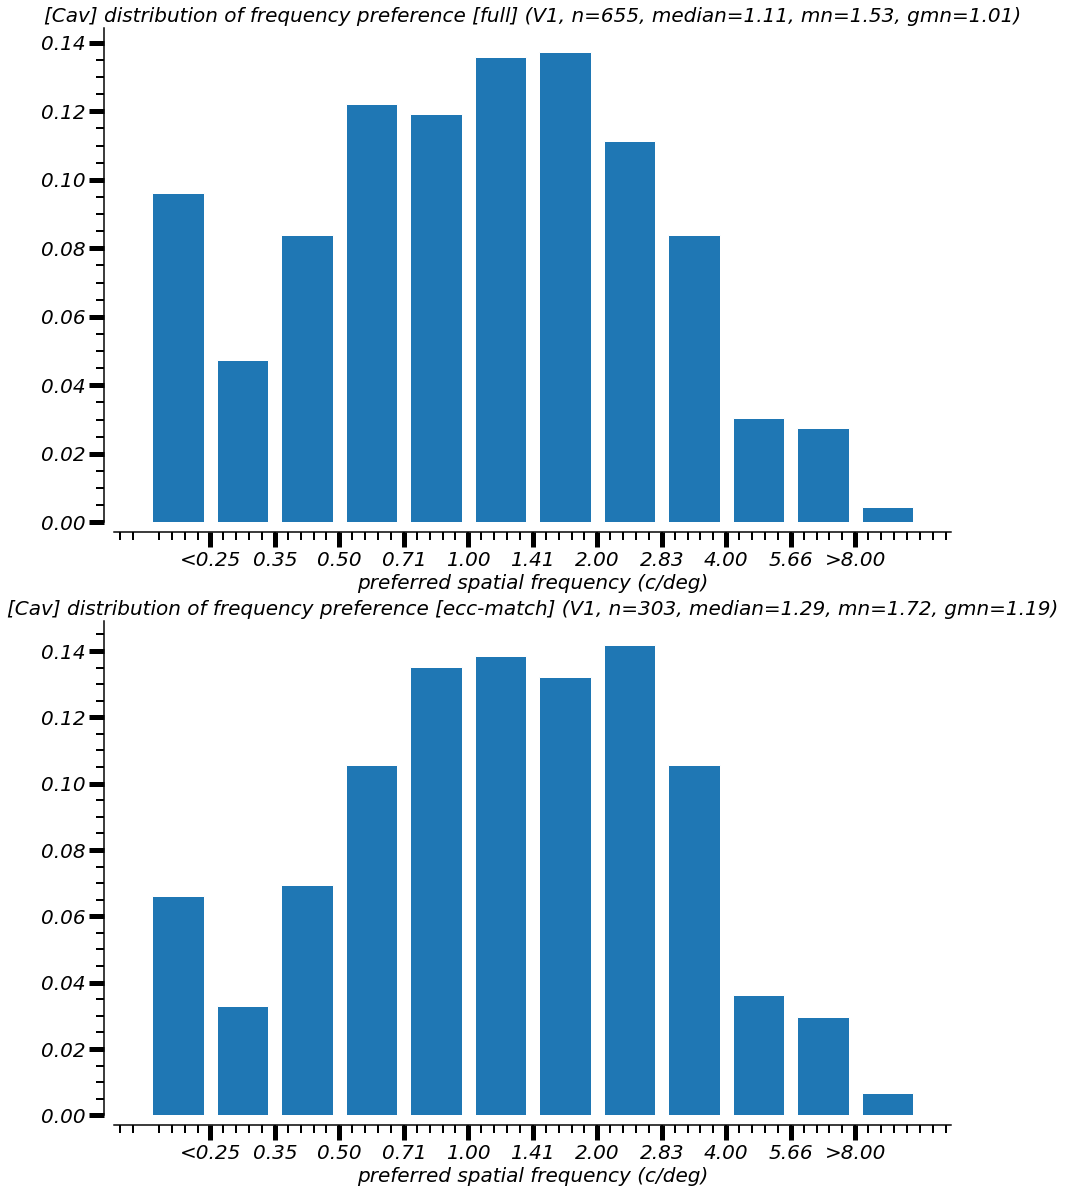

In [12]:
f, ax = plt.subplots(2, 1, figsize=(15, 2*10))
# ax.set(xscale="log")

for i in range(2):

    plt.subplot(2,1,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.xlabel('preferred spatial frequency (c/deg)');
    plt.title('[Cav] distribution of frequency preference [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSF[i], medianSF[i], mnSF[i], gmnSF[i]));


##### Cav: bandwidth

First, we ask: are the bandwidths given in octaves or linear c/deg?

In [ ]:
all_ok = np.logical_and(~np.isnan(cav_psf), ~np.isnan(cav_sfBw))
fit_mod = np.polyfit(cav_psf[all_ok], cav_sfBw[all_ok], deg=1)

In [ ]:
all_ok = np.logical_and(~np.isnan(cav_psf), ~np.isnan(cav_sfBw))
# returns a, b in a*x + b
fit_mod = np.polyfit(np.log2(cav_psf[all_ok]), cav_sfBw[all_ok], deg=1)

plt.subplots(figsize=(8, 6))
plt.plot(cav_psf, cav_sfBw, 'o')
# plot the linear fit on log-lin (x-y) coords.
all_sfs = np.geomspace(0.1, 10, 100);
plt.plot(all_sfs, np.log2(all_sfs)*fit_mod[0] + fit_mod[1], 'k--')
plt.xscale('log')
plt.xlabel('preferred spatial frequency (c/deg)')
plt.ylabel('SF bandwidth (oct? c/deg?)')
sns.despine(offset=10, trim=False)

The relative lack of (or even slightly negative) correlation between preferred spatial frequency and bandwidth measure suggests that the latter measure is given in octaves, not linear cycles per degree. Why? Well, neurons with higher preferred SF have a larger linear bandwidth, but generally octave bandwidth remains constant as a function of preferred SF.

In [ ]:
bins = np.linspace(0, 6, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

sfBWs = [cav_sfBw, cav_sfBwEcc];
fitStr = ['full', 'ecc-match']

bw_clipped = [np.clip(hf.nan_rm(x), clipLow, clipHigh) for x in sfBWs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# calculate
nBW = [len(x) for x in bw_clipped]
medianBW = [np.nanmedian(x) for x in sfBWs];
mnBW = [np.nanmean(x) for x in sfBWs];

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(15, 2*10))
# ax.set(xscale="log")

for i in range(2):

    plt.subplot(2,1,1+i)
    vals, _ = np.histogram(bw_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % x for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.xlabel('spatial frequency bandwidth (oct)');
    plt.title('Distribution of half-height bandwidth [%s] (V1, n=%d, median=%.2f, mn=%.2f)' % (fitStr[i], nBW[i], medianBW[i], mnBW[i]));

#### (return to my data) Plot the distribution of preferred frequency:

In [ ]:
bins = np.linspace(-2.5, 3.5, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

psfs = [pSfHighCon, dog_pSfHighCon];
fitStr = ['flex', 'DoG']

psfs_clipped = [np.clip(hf.nan_rm(np.log2(x)), clipLow, clipHigh) for x in psfs];
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nSF = [len(x) for x in psfs_clipped]
medianSF = [np.nanmedian(x) for x in psfs];
mnSF = [np.nanmean(x) for x in psfs];
gmnSF = [gmean(hf.nan_rm(x)) for x in psfs];

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(15, 2*10))
# ax.set(xscale="log")

for i in range(2):

    plt.subplot(2,1,1+i)
    vals, _ = np.histogram(psfs_clipped[i], bins=bins)
    vals_norm = vals/np.sum(vals)
    plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
    sns.despine(offset=10)
    tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
    tickStrs[0] = '<%s' % tickStrs[0];
    tickStrs[-1] = '>%s' % tickStrs[-1];
    plt.xticks(tickVals, tickStrs);

    plt.xlabel('preferred spatial frequency (c/deg)');
    plt.title('Distribution of frequency preference [%s] (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (fitStr[i], nSF[i], medianSF[i], mnSF[i], gmnSF[i]));


##### Compare to existing measurements:

**DeValois, Albrecht, Thorell (1982):**
Here, they split their data by X&Y, foveal ($[0^{\circ}, 1.5^{\circ}]$) and parafoveal ($[3^{\circ}, 5^{\circ}]$). Our data are parafoveal if not further, so we expect that our distribution of peak frequencies will be comparable to their X/Y parafoveal data, if not shifted lower, since we expect a fall-off in peak frequency with eccentricity (i.e., the highest peak frequency drops as a function of eccentricity, [DeValois & DeValois, 1980]). They have a mean of 2.2/3.2 cpd for Y/X parafoveal cells; our mean/gmean is 3.45/2.76 cpd. **Our cells are "in the ballpark".**

<img src="figures/dv-sf.png" width=400 />

**Cavanaugh (intra-lab dataset):**
See the above - his distribution has a substantially lower preferred spatial frequency (mean between 1.5 - 1.7 cpd, depending on full or eccentricity-matched dataset).

#### Plot the distribution of characteristic frequency:

In [ ]:
bins = np.linspace(-0.5, 4.5, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;

char_clipped = np.clip(hf.nan_rm(np.log2(dog_charFreqHighCon)), clipLow, clipHigh);
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
# tickVals = np.linspace(bins[1]+0.5*stepSize, bins[-2]+0.5*stepSize, 10)

# calculate
nCF = len(char_clipped)
medianCF = np.nanmedian(dog_charFreqHighCon)
mnCF = np.nanmean(dog_charFreqHighCon);
gmnCF = gmean(hf.nan_rm(dog_charFreqHighCon));

In [ ]:
f, ax = plt.subplots(figsize=(15, 10))

vals, _ = np.histogram(char_clipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(offset=10)
tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
plt.xticks(tickVals, tickStrs);

plt.xlabel('characteristic spatial frequency (c/deg)');
plt.title('Distribution of characteristic frequency (V1, n=%d, median=%.2f, mn=%.2f, gmn=%.2f)' % (nCF, medianCF, mnCF, gmnCF));


#### Plot the distribution of frequency tuning bandwidth:

First, half-height

In [ ]:
bins = np.linspace(0, 6, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
bwHalfClipped = np.clip(hf.nan_rm(bwHalfHighCon), clipLow, clipHigh)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# compute
nBW = len(bwHalfClipped);
medianBW = np.nanmedian(bwHalfHighCon);
mnBW = np.nanmean(bwHalfHighCon);

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
# ax.set(xscale="log")

vals, _ = np.histogram(bwHalfClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(offset=10)
tickStrs = ['%.2f' % x for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
plt.xticks(tickVals, tickStrs);

plt.xlabel('spatial frequency bandwidth (oct)');
plt.title('Distribution of half-height bandwidth (V1, n=%d, median=%.2f, mn=%.2f)' % (nBW, medianBW, mnBW));

#### Compare to existing measurements:

**DeValois, Albrecht, Thorell (1982):**
Here, they split their data by X&Y, foveal ($[0^{\circ}, 1.5^{\circ}]$) and parafoveal ($[3^{\circ}, 5^{\circ}]$). 
Our data are parafoveal if not further, so we expect that our distribution of bandwidth will be comparable to their X/Y parafoveal data. They have a mean of 1.6/1.32 octaves for Y/X parafoveal cells; our mean/median is 2.45/2.77 octaves. **Our cells are more broadly tuned. Why?**

<img src="figures/dv-bw.png" width=400 />

**Cavanaugh (intra-lab dataset):**
Our bandwidth measures are comparable (median/mean around 2.1/2.2 octaves), though ours are still broader. Note that we have assumed his measurements are given in octaves (and not linear CPD).

Then, three-fourth height

In [ ]:
bins = np.linspace(0, 4, 13);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
bw34Clipped = np.clip(hf.nan_rm(bw34HighCon), clipLow, clipHigh)
tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)

# compute
nBW = len(bw34Clipped);
medianBW = np.nanmedian(bw34HighCon);
mnBW = np.nanmean(bw34HighCon);

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
vals, _ = np.histogram(bw34Clipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
sns.despine(offset=10)
tickStrs = ['%.2f' % x for x in tickVals];
tickStrs[0] = '<%s' % tickStrs[0];
tickStrs[-1] = '>%s' % tickStrs[-1];
plt.xticks(tickVals, tickStrs);

plt.xlabel('spatial frequency bandwidth (oct)');
plt.title('Distribution of 3/4-height bandwidth (V1, n=%d, median=%.2f, median=%.2f)' % (nBW, medianBW, mnBW));

### Relating fit quality to fit parameters

In [ ]:
pSfHighCon = np.array([jointList[i]['metrics']['pSf'][disp][con] for i in range(len(jointList))])
bwHalfHighCon = np.array([jointList[i]['metrics']['bwHalf'][disp][con] for i in range(len(jointList))])
bw34HighCon = np.array([jointList[i]['metrics']['bw34'][disp][con] for i in range(len(jointList))])

In [ ]:
dispInd, conInd = 0, -1;
# for high contrast, single gratings
descrVarExpl = [jointList[x]['metrics']['sfVarExpl'][dispInd][conInd] for x in range(len(jointList))]
dogVarExpl = [jointList[x]['metrics']['dog_varExpl'][dispInd][conInd] for x in range(len(jointList))]

In [ ]:
nMods, nComps = 2, 3;
f, ax = plt.subplots(nMods, nComps, figsize=(nComps*7, nMods*8))

allVar = [descrVarExpl, dogVarExpl];
modStr = [hf.descrMod_name(0), hf.descrMod_name(1)]; # 0 [flex], 1 [sach], 2[tony]

f.suptitle('Do the descriptive fits fail with particular tuning properties?')

for i in range(len(allVar)):

    ### compute the correlations
    jointNan = np.logical_or(np.isnan(allVar[i]), np.isnan(pSfHighCon));
    r = np.corrcoef(np.array(allVar[i])[~jointNan], pSfHighCon[~jointNan])
    rSf = r[0, 1]; # [0,1] and [1,0] are the same - corr. b/t "x" and "y"
    # bwHalf
    jointNan = np.logical_or(np.isnan(allVar[i]), np.isnan(bwHalfHighCon));
    r = np.corrcoef(np.array(allVar[i])[~jointNan], bwHalfHighCon[~jointNan])
    rBw = r[0, 1]; # [0,1] and [1,0] are the same - corr. b/t "x" and "y"
    # bw34
    jointNan = np.logical_or(np.isnan(allVar[i]), np.isnan(bw34HighCon));
    r = np.corrcoef(np.array(allVar[i])[~jointNan], bw34HighCon[~jointNan])
    rBw34 = r[0, 1]; # [0,1] and [1,0] are the same - corr. b/t "x" and "y"
    
    # first, varExpl vs. prefSf
    ax[i, 0].semilogy(allVar[i], pSfHighCon, 'o')
    ax[i, 0].set_xlabel('% variance explained')
    ax[i, 0].set_ylabel('preferred SF (c/deg)')
    ax[i, 0].set_title('%s model (r=%.2f)' %  (modStr[i], rSf));
    # then, varExpl vs. sfBw (1/2)
    ax[i, 1].plot(allVar[i], bwHalfHighCon, 'o')
    ax[i, 1].set_xlabel('% variance explained')
    ax[i, 1].set_ylabel('bandwidth (1/2; oct)')
    ax[i, 1].set_title('(r=%.2f)' % rBw)
    # finally, varExpl vs. sfBw (3/4)
    ax[i, 2].plot(allVar[i], bw34HighCon, 'o')
    ax[i, 2].set_xlabel('% variance explained')
    ax[i, 2].set_ylabel('bandwidth (3/4; oct)')
    ax[i, 2].set_title('(r=%.2f)' % rBw34)


## Simple vs complex
How do the tuning properties above vary with F1/F0 ratio? Here, I compute the F1/F0 ratio based on the responses to the optimial single grating SF at high contrast. I take the F0 and F1 values for each repeat of that condition, and compute the mean of all individual trial ratios.

In [ ]:
nCells = len(jointList)
f1f0_rats = np.array([jointList[i]['metrics']['f1f0_ratio'] for i in range(nCells)])
f1f0_saveName = 'simple_complex_distr_UPDATE.pdf'

In [ ]:
nRows = 3
f, ax = plt.subplots(nRows, 1, figsize=(1*7, nRows*10))

nS, nC = sum(f1f0_rats>1), sum(f1f0_rats<1)
ax[0].hist(hf.nan_rm(f1f0_rats), bins=11, label='%d(s), %d(c)' % (nS, nC));
ax[0].axvline(1.0, ls='--', color='k');
ax[0].set_title('F1::F0 ratio - linear scale')
ax[0].legend();

fracS = nS/(nS+nC);
bins = ax[1].hist(hf.nan_rm(np.log10(f1f0_rats)), bins=9, label='%.1f%% simple' % (100*fracS))[1];
ax[1].axvline(0, ls='--', color='k');
ax[1].set_title('F1::F0 ratio - log10 scale')
ax[1].legend();

# NOTE: Cavanaugh's F1F0 ratio seems to be in the 'complexity' field, and is already log(base10) transformed
cav_complexity = hf.nan_rm(df['complexity'])
c_nS, c_nC = sum(cav_complexity>0), sum(cav_complexity<0)
ax[2].hist(cav_complexity, bins=bins, label='%.1f%% simple' % (100*(c_nS/(c_nS+c_nC))));
ax[2].axvline(0, ls='--', color='k');
ax[2].set_title('F1::F0 ratio - Cavanaugh')
ax[2].legend();

sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + f1f0_saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


In [ ]:
nRows = 3
f, ax = plt.subplots(nRows, 1, figsize=(1*7, nRows*10))

nS, nC = sum(f1f0_rats>1), sum(f1f0_rats<1)
ax[0].hist(hf.nan_rm(f1f0_rats), bins=11, label='%d(s), %d(c)' % (nS, nC));
ax[0].axvline(1.0, ls='--', color='k');
ax[0].set_title('F1::F0 ratio - linear scale')
ax[0].legend();

fracS = nS/(nS+nC);
bins = ax[1].hist(hf.nan_rm(np.log10(f1f0_rats)), bins=7, label='%.1f%% simple' % (100*fracS))[1];
ax[1].axvline(0, ls='--', color='k');
ax[1].set_title('F1::F0 ratio - log10 scale')
ax[1].legend();

# NOTE: Cavanaugh's F1F0 ratio seems to be in complexity, and is already log(base10) transformed
cav_complexity = hf.nan_rm(df['complexity'])
c_nS, c_nC = sum(cav_complexity>0), sum(cav_complexity<0)
ax[2].hist(cav_complexity, bins=bins, label='%.1f%% simple' % (100*(c_nS/(c_nS+c_nC))));
ax[2].axvline(0, ls='--', color='k');
ax[2].set_title('F1::F0 ratio - Cavanaugh')
ax[2].legend();

sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + f1f0_saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


From the above plots, we can see that the f1/f0 ratios in my V1 dataset are comparable to Cavanaugh's, both in "sign" and magnitude

In [ ]:
f1f0tuning_name = 'f1f0_tuning.pdf';

In [ ]:
# using for colors
zTO1 = lambda x: np.divide(x - np.nanmin(x), np.nanmax(x - np.nanmin(x)));

In [ ]:
nCols = 2; # each of the below measures will have two types to analyze
nMeasure = 2; # central tendency of SF, variance of S

f, ax = plt.subplots(nMeasure, nCols, figsize=(10*nCols, 10*nMeasure));
# we'll color each point according to the log10'd f1f0 ratio (this scale is more uniform)
log10_f1f0rats = np.log10(f1f0_rats);
clrs = cm.gray(np.ones_like(log10_f1f0rats) - 0.75);
lt0 = np.where(log10_f1f0rats < 0)[0];
clrs[lt0, :] = cm.gray(np.ones_like(lt0) - 0.25);
# clrs = cm.gray(zTO1(log10_f1f0rats));

# first, C.o.M. and pSF
metrics = [comHighCon, pSfHighCon];
labels = ['center of mass', 'preferred SF'];
for ind, (m, l) in enumerate(zip(metrics, labels)):
    ax[0, ind].scatter(m, log10_f1f0rats, color=clrs)
    ax[0, ind].set_ylabel('log10 f1f0 ratio');
    ax[0, ind].set_xlabel('spatial frequency (c/deg)');
    ax[0, ind].set_title('%s' % l)
    ax[0, ind].set_xscale('log')

# second, sfVar and bw34
metrics = [varHighCon, bw34HighCon];
labels = ['sfVar', 'bw34 (oct)'];
for ind, (m, l) in enumerate(zip(metrics, labels)):
    ax[1, ind].scatter(m, log10_f1f0rats, color=clrs)
    ax[1, ind].set_ylabel('log10 f1f0 ratio');
    ax[1, ind].set_xlabel('%s' % l);
    ax[1, ind].set_title('tuning curve breadth')
    
sns.despine(offset=10)

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + f1f0tuning_name);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()


## Shifts in tuning with contrast

### Preferred spatial frequency with contrast inferred from descriptive fit to pSf vs. con

Now, we plot the ratio of preferred spatial frequencies in the data set. Here, we are using "pSfModRat" - a derived measure in which we fit a simple polynomial equation to the preferred frequencies as a function of contrast (see descr_fits.py for details).

- In [0, 0], the ratio of preferred spatial frequencies ($\frac{con_a}{con_b}$) evaluated at the extrema contrasts
- In [0, 1], the ratio of preferred spatial frequencies is expressed per unit log2 contrast

In [ ]:
saveName = 'sfAllConRatio_%s.pdf' % fitBase

# [0, 0] for single gratings, ratio
# [0, 1] for single gratings, ratio per unit log2 contrast
psfModRats = [jointList[i]['metrics']['pSfModRat'][0, 1] for i in range(len(jointList))];
psfModRats = np.array(psfModRats);

bins = np.linspace(-1.25, 1.25, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
psfClipped = np.clip(psfModRats, bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

In [ ]:
jointList[40]['metrics'].keys()

In [ ]:
f = plt.figure(figsize=(12, 8))

vals, _ = np.histogram(psfClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(psfModRats), np.nanmedian(psfModRats)];
std = np.nanstd(psfModRats);
stdAsRatio = std/np.power(2, mean);
plt.plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f) +/- %.0f%%' % (np.power(2, mean), 100*stdAsRatio));
plt.plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median));
plt.axvline(0, ls='--', c='k', label='no effect')
plt.legend(fontsize='x-small');
plt.xticks(tickVals, ['%.2f' % np.power(2, x) for x in tickVals]);
plt.xlabel('prefSF ratio per log2 contrast');
plt.title('Preferred SF changes with contrast (n=%d)' % sum(vals), fontsize='small');
sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

...aside: suppose want to look at cells where the ratio shift is in the top 25% (i.e. highest):

In [ ]:
nan_rm = lambda x: x[~np.isnan(x)]

prctile = 75;
thresh = np.percentile(nan_rm(psfModRats), prctile)
# thresh = np.percentile(np.abs(nan_rm(psfRats)), prctile)
shiftCells = np.where(psfModRats>thresh)[0]

allChiDiffs = [];

for i in shiftCells:
    currEntry = jointList[i];
    currName = currEntry['metadata']['expName'];
    try:
        flat, wght = currEntry['model']['NLL_flat'], currEntry['model']['NLL_wght'];
        chiSqDiff = flat-wght;
        allChiDiffs.append(chiSqDiff);
        print('%s: flat|wght is (%.2f|%.2f)' % (currName, flat, wght));
    except: # no fit for this cell
        pass
    
sns.distplot(allChiDiffs, kde=False);
sns.despine(offset=10);

### Preferred spatial frequency with contrast from data, 1:.33 contrast

In [ ]:
saveName = 'sfFixConRatioNorm_%s.pdf' % fitBase;

# get psfRatio 1:.33 contrast (raw value, not norm. to con value)
disp = 0; # i.e. single gratings
toNorm = 0;
if toNorm == 1:
    conNorm = np.log2(1/0.33);
else:
    conNorm = 1;
    
# why ['diffsAtThirdCon'][2] - [2] is pSf
psfRats = [jointList[i]['metrics']['diffsAtThirdCon'][disp, 2]/conNorm for i in range(len(jointList))];
psfRats = np.array(psfRats);

bins = np.linspace(-1.25, 1.25, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
psfClipped = np.clip(psfRats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

In [ ]:
f = plt.figure(figsize=(12, 8))

vals, _ = np.histogram(psfClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(psfRats), np.nanmedian(psfRats)];
std = np.nanstd(psfRats);
stdAsRatio = std/np.power(2, mean);
plt.plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f) +/- %.0f%%' % (np.power(2, mean), 100*stdAsRatio));
plt.plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % np.power(2, median));
plt.axvline(0, ls='--', c='k', label='no effect')
plt.legend(fontsize='x-small', loc='upper left');
plt.xticks(tickVals, ['%.2f' % np.power(2, x) for x in tickVals]);
plt.xlabel('prefSF ratio (1::0.33 contrast)');
plt.title('Preferred SF changes with contrast (n=%d)' % sum(vals), fontsize='small');
sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

##### Are these differences significant?
The way to test this is a paired t-test, since want to know if the two samples of the metric (e.g. preferred frequency at two different contrasts) have a different mean.

In [ ]:
highCon = hf.jl_get_metric_byCon(jointList, 'pSf', conVal=1.0, disp=0)
lowCon  = hf.jl_get_metric_byCon(jointList, 'pSf', conVal=0.33, disp=0)
non_nan = np.logical_and(~np.isnan(highCon), ~np.isnan(lowCon));

In [ ]:
paired_t = ss.ttest_rel(highCon[non_nan], lowCon[non_nan])
pval = paired_t.pvalue;
if pval <= 0.05:
    print('significant! p=%.2e (n=%d)' % (pval, sum(non_nan)));
elif paired_t.pvalue > 0.05:
    print('not significant! p=%.2e (n=%d)' % (pval, sum(non_nan)));

### But now with center of mass!

In [ ]:
# get psfRatio 1:.33 contrast (raw value, not norm. to con value)
disp = 0; # i.e. single gratings

toNorm = 0;
if toNorm == 1:
    conNorm = np.log2(1/0.33);
    normStr = 'Norm'
else:
    conNorm = 1;
    normStr = ''

saveName = 'sfComFixConRatio%s_%s.pdf' % (normStr, fitBase);
    
# why ['diffsAtThirdCon'][4] - [4] is center of mass ratio
comRats = [jointList[i]['metrics']['diffsAtThirdCon'][disp, 4]/conNorm for i in range(len(jointList))];
comRats = np.array(comRats);

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(12, 2*12))

### same scale as pSf above
bins = np.linspace(-1.25, 1.25, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
comClipped = np.clip(comRats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

vals, _ = np.histogram(comClipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[0].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(comRats), np.nanmedian(comRats)];
std = np.nanstd(comRats);
stdAsRatio = std/np.power(2, mean);
ax[0].plot(mean, 1.25*np.max(vals_norm), 'v', markersize=10, label='mean (%.2f) +/- %.0f%%' % (np.power(2, mean), 100*stdAsRatio));
ax[0].plot(median, 1.25*np.max(vals_norm), 'v', markersize=10, label='median (%.2f)' % np.power(2, median));
ax[0].axvline(0, ls='--', c='k', label='no effect')
ax[0].legend(fontsize='x-small', loc='upper left');
ax[0].set_xticks(tickVals)
ax[0].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);
ax[0].set_xlabel('c.o.m. ratio (1::0.33 contrast)');
ax[0].set_title('Center-of-mass changes with contrast (n=%d)' % sum(vals), fontsize='small');
sns.despine(offset=10)

### better scale given range of c.o.m.
bins = np.linspace(-0.5, 0.5, 9);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
comClipped = np.clip(comRats, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

vals, _ = np.histogram(comClipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[1].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(comRats), np.nanmedian(comRats)];
std = np.nanstd(comRats);
stdAsRatio = std/np.power(2, mean);
ax[1].plot(mean, 1.25*np.max(vals_norm), 'v', markersize=10, label='mean (%.2f) +/- %.0f%%' % (np.power(2, mean), 100*stdAsRatio));
ax[1].plot(median, 1.25*np.max(vals_norm), 'v', markersize=10, label='median (%.2f)' % np.power(2, median));
ax[1].axvline(0, ls='--', c='k', label='no effect')
ax[1].legend(fontsize='x-small', loc='upper left');
ax[1].set_xticks(tickVals);
ax[1].set_xticklabels(['%.2f' % np.power(2, x) for x in tickVals]);
ax[1].set_xlabel('c.o.m. ratio (1::0.33 contrast)');
ax[1].set_title('Center-of-mass changes with contrast (n=%d)' % sum(vals), fontsize='small');
sns.despine(offset=10)


if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

##### Are these differences significant?

In [ ]:
highCon = hf.jl_get_metric_byCon(jointList, 'sfCom', conVal=1.0, disp=0)
lowCon  = hf.jl_get_metric_byCon(jointList, 'sfCom', conVal=0.33, disp=0)
non_nan = np.logical_and(~np.isnan(highCon), ~np.isnan(lowCon));

In [ ]:
paired_t = ss.ttest_rel(highCon[non_nan], lowCon[non_nan])
pval = paired_t.pvalue;
if pval <= 0.05:
    print('significant! p=%.2e (n=%d)' % (pval, sum(non_nan)));
elif paired_t.pvalue > 0.05:
    print('not significant! p=%.2e (n=%d)' % (pval, sum(non_nan)));

### Bandwidth with contrast from data, 1:.33 contrast

In [ ]:
saveBase = lambda s: 'bwFixedCons%s_%s.pdf' % (s, fitBase);

disp = 0; # looking at single gratings
# get bw diff 1:.33 contrast (raw value, not norm. to con value)
bwAt = 0; # 0 - half-height; 1 - 3/4 height

bwStr = ['1/2 ht', '3/4 ht'];
bwSaveStr = ['_hh', '_3qh'];

bwDiff = [jointList[i]['metrics']['diffsAtThirdCon'][disp, bwAt] for i in range(len(jointList))];
bwDiff = np.array(bwDiff);

bins = np.linspace(-2.5, 2.5, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
bwClipped = np.clip(bwDiff, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

In [ ]:
np.argsort(bwDiff)

In [ ]:
f = plt.figure(figsize=(12, 8))

vals, _ = np.histogram(bwClipped, bins=bins)
vals_norm = vals/np.sum(vals)
plt.bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(bwDiff), np.nanmedian(bwDiff)];
std = np.nanstd(bwClipped);
# stdAsRatio = 0
stdAsRatio = std/mean;
plt.plot(mean, 1.25*np.max(vals_norm), 'v', markersize=10, label='mean (%.2f) +/- %.0f%%' % (mean, 100*stdAsRatio));
plt.plot(median, 1.25*np.max(vals_norm), 'v', markersize=10, label='median (%.2f)' % median);
plt.axvline(0, ls='--', c='k', label='no effect')
plt.legend(fontsize='x-small');
plt.xlabel('octave bandwidth difference (1::0.33 contrast)');
plt.title('Bandwidth SF changes with contrast (n=%d, %s)' % (sum(vals), bwStr[bwAt]), fontsize='small');
sns.despine(offset=10)

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
saveName = saveBase(bwSaveStr[bwAt])
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

In [ ]:
# test for significance
metr = ['bwHalf', 'bw34']

for m in metr:

    highCon = hf.jl_get_metric_byCon(jointList, m, conVal=1.0, disp=0)
    lowCon  = hf.jl_get_metric_byCon(jointList, m, conVal=0.33, disp=0)
    non_nan = np.logical_and(~np.isnan(highCon), ~np.isnan(lowCon));

    paired_t = ss.ttest_rel(highCon[non_nan], lowCon[non_nan])
    pval = paired_t.pvalue;
    if pval <= 0.05:
        print('%s: significant! p=%.2e (n=%d)' % (m, pval, sum(non_nan)));
    elif paired_t.pvalue > 0.05:
        print('%s not significant! p=%.2e (n=%d)' % (m, pval, sum(non_nan)));

### Now with model-free metric

In [ ]:
saveBase = lambda s: 'bwVarFixedCons_%s.pdf' % (fitBase);

disp = 0;
# why ['diffsAtThirdCon'][3]? [3] is model-free variance measure
varDiff = [jointList[i]['metrics']['diffsAtThirdCon'][disp, 3] for i in range(len(jointList))];
varDiff = np.array(varDiff);

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(12, 2*12))

### first, same scale as above

bins = np.linspace(-2.5, 2.5, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
varClipped = np.clip(varDiff, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

vals, _ = np.histogram(varClipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[0].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(varDiff), np.nanmedian(varDiff)];
std = np.nanstd(varClipped);
# stdAsRatio = 0
stdAsRatio = std/mean;
ax[0].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f) +/- %.0f%%' % (mean, 100*stdAsRatio));
ax[0].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % median);
ax[0].axvline(0, ls='--', c='k', label='no effect')
ax[0].legend(fontsize='x-small');
ax[0].set_xlabel('sfVar difference (1::0.33 contrast)');
ax[0].set_title('SF variance changes with contrast (n=%d)' % (sum(vals)), fontsize='small');
sns.despine(offset=10)

### then, better scale for this metric

bins = np.linspace(-0.5, 0.5, 11);
stepSize = (bins[-1] - bins[0])/(len(bins)-1);
binPlotLocs = bins[1:] - 0.5*stepSize;
varClipped = np.clip(varDiff, bins[0]+0.5*stepSize, bins[-1]-0.5*stepSize)

tickVals = np.linspace(bins[1], bins[-2], 5);

vals, _ = np.histogram(varClipped, bins=bins)
vals_norm = vals/np.sum(vals)
ax[1].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center');
mean, median = [np.nanmean(varDiff), np.nanmedian(varDiff)];
std = np.nanstd(varClipped);
# stdAsRatio = 0
stdAsRatio = std/mean;
ax[1].plot(mean, 1.25*np.max(vals_norm), 'v', label='mean (%.2f) +/- %.0f%%' % (mean, 100*stdAsRatio));
ax[1].plot(median, 1.25*np.max(vals_norm), 'v', label='median (%.2f)' % median);
ax[1].axvline(0, ls='--', c='k', label='no effect')
ax[1].legend(fontsize='x-small');
ax[1].set_xlabel('sfVar difference (1::0.33 contrast)');
ax[1].set_title('SF variance changes with contrast (n=%d)' % (sum(vals)), fontsize='small');
sns.despine(offset=10)

### now save

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
saveName = saveBase(bwSaveStr)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

In [ ]:
# test for significance
m = 'sfVar'

highCon = hf.jl_get_metric_byCon(jointList, m, conVal=1.0, disp=0)
lowCon  = hf.jl_get_metric_byCon(jointList, m, conVal=0.33, disp=0)
non_nan = np.logical_and(~np.isnan(highCon), ~np.isnan(lowCon));

paired_t = ss.ttest_rel(highCon[non_nan], lowCon[non_nan])
pval = paired_t.pvalue;
if pval <= 0.05:
    print('%s: significant! p=%.2e (n=%d)' % (m, pval, sum(non_nan)));
elif paired_t.pvalue > 0.05:
    print('%s not significant! p=%.2e (n=%d)' % (m, pval, sum(non_nan)));

### Show the trajectory of these measures across all contrasts
Rather than simply analyzing the ratio at any two contrasts, let's consider the evolution of these measures across all contrasts (for a given cell and dispersion)

In [ ]:
#######
# First, decide which measure we're using; prepare plot
#######
subset = ['all', 'V1orig', 'V1new']

sfMetrics = ['sfCom', 'pSf', 'bwHalf'];
nMetrics = len(sfMetrics);
metricColor = ['k', 'b', 'g']

# allCon_sf  = dict();
# allCon_con = dict();

nCells = len(jointList);

maxCons = np.max([len(jointList[i]['metadata']['stimVals'][1]) for i in range(nCells)]); # max nCons
# dispColor = cm.rainbow(np.linspace(0, 1, maxDisp));

for mtr, mtrClr in zip(sfMetrics, metricColor):

    for sub_ind, sbst in zip(range(len(subset)), subset):
    
        saveName = 'sfTune_conTrends_%s_%s.pdf' % (mtr, sbst)

        #######
        # subset the data
        #######
        
        # first, determine which cells we'll consider
        expInds = np.array([jointList[i]['metadata']['expInd'] for i in range(nCells)])
        if sub_ind == 0: # all data
            # NOTE: yes, we could just grab 'median', but want to track # cells
            ok = np.where(expInds > 0)[0]; # i.e. any experiment...
        elif sub_ind == 1: # V1_orig
            ok = np.where(expInds == 1)[0]
        elif sub_ind == 2: # V1
            ok = np.where(expInds != 1)[0]
    
        # how to handle contrast? for each cell, find the contrast that is valid for that dispersion and matches the con_lvl
        # to within some tolerance (e.g. +/- 0.01, i.e. 1% contrast)

        #######
        # set up plot, analyses
        #######
        maxDisp = np.max([len(jointList[i]['metadata']['stimVals'][0]) for i in ok]) # 0 for disps...
        dispColor = cm.rainbow(np.linspace(0, 1, maxDisp));
        f, ax = plt.subplots(maxDisp, 2, figsize=(2*20, nMetrics*20));

        full_slope = [];
        prev_ahh = None; # store previous median slope value

    #     allDisp_sf[con_ind] = dict();
    
        for d, clr in zip(range(maxDisp), dispColor):

            all_sfs = [];
            all_cons = [];
            all_slopes = [];

            for i in ok:

                #######
                # get structure, metadata, etc
                #######
                curr_cell = jointList[i]
                curr_metr = curr_cell['metrics']['%s' % mtr];
                curr_meta = curr_cell['metadata'];
                curr_cons = curr_meta['stimVals'][1];
                curr_byDisp = curr_meta['val_con_by_disp'];
                if d < len(curr_byDisp):
                    curr_inds = curr_byDisp[d];
                else:
                    continue; # i.e. this dispersion isn't ther

                curr_conVals = np.array(curr_cons[curr_inds]);
                curr_metrVal = np.array(curr_metr[d, curr_inds]);

                #######
                # slope measure
                # get a slope for how the metric changes with dispersion...mostly just interested in sign (+/-)
                #######
                non_nan = ~np.isnan(curr_metrVal);
                if np.array_equal(np.unique(non_nan), [False]): # i.e. all are nan
                    curr_slope = np.nan
                else:
                    curr_slope = linregress(np.log2(curr_conVals[non_nan]), curr_metrVal[non_nan])[0];

                all_sfs.append(curr_metrVal);
                all_cons.append(curr_conVals);
                all_slopes.append(curr_slope);

                #######
                # now plot!
                #######

                ax[d, 0].semilogx(curr_conVals, curr_metrVal, linestyle='--', alpha=0.3, color=clr);
                ax[d, 0].set_title('metric: %s' % mtr)

            #######
            # gather for everything, plot
            #######
#             if np.array_equal(all_cons, []):
#                 continue; # what does this mean? When we subset the data, not all dispersions are
            full_slope.append(np.array(all_slopes));

            # now take median, save
            stacked_cons = np.hstack([x for x in all_cons]);
            unique_cons = np.unique(stacked_cons);
            mdn = [];
            for c_lvl in unique_cons:
                ind_byCell = [np.where(x==c_lvl)[0] for x in all_cons]
                sf_byCell = np.array([x[i] for x, i in zip(all_sfs, ind_byCell)]);
                valids = np.hstack([x for x in sf_byCell]);
                mdn.append(np.nanmedian(valids));

            # then plot the median!
            ax[d, 0].semilogx(unique_cons, mdn, '-', linewidth=4, color=clr);

    #         clean up plot
            sns.despine(offset=10);
            ax[d, 0].set_xlabel('contrast');
            ax[d, 0].set_ylabel('%s' % mtr);


            #######
            # now plot hist of slopes
            #######
            cleaned = np.clip(hf.nan_rm(np.array(all_slopes)), -2, 2);
            ax[d, 1].hist(cleaned, color=clr);
            ahh = np.nanmedian(all_slopes);
            ax[d, 1].plot(ahh, -1, 'v', color=clr, markersize=10, label='mdn: (%.2f) (disp: %s)' % (ahh, d+1))
            if prev_ahh is not None:
                ax[d, 1].plot(prev_ahh, -1, 'v', color=prev_clr, markersize=10)
            ax[d, 1].set_xlabel('slope value')
            ax[d, 1].set_ylabel('# cells')
            ax[d, 1].legend();
            ax[d, 1].set_title('slope of metric vs. contrast')
            prev_ahh = ahh;
            prev_clr = clr;

        f.suptitle('tuning measure vs. contrast across dispersion %s' % sbst);

    #######
    # save
    #######

#     if not os.path.exists(save_loc):
#         os.makedirs(save_loc)
#     pdfSv = pltSave.PdfPages(save_loc + saveName);
#     pdfSv.savefig(f) # only one figure here...
#     pdfSv.close()


In [ ]:
%debug

## Preferred spatial frequency with contrast *and* dispersion

Before we ask "how correlated are the frequency shifts at different dispersion levels", let's first consider the central/preferred frequency as a function of dispersion alone, i.e. start with the constituent parts of the ratios.

### Histograms/trajectories of metrics with dispersion, split by contrast

In [ ]:
#######
# First, decide which measure we're using; prepare plot
#######
sfMetrics = ['sfCom', 'pSf', 'sfComCut'];
nMetrics = len(sfMetrics);
metricColor = ['k', 'b', 'g']
con_tol = 0.02;
slope_clip = [-2, 2]; # we're clipping the slope measure for better visualization; see "slope" below


con_lvls = [0.33, 0.47, 0.68, 1.00];

allCon_sf  = dict();
allCon_con = dict();

for con_ind in range(len(con_lvls)):

    con_lvl = con_lvls[con_ind];
    saveName = 'sf_disp_con%03d.pdf' % (100*con_lvl)

    # how to handle contrast? for each cell, find the contrast that is valid for that dispersion and matches the con_lvl
    # to within some tolerance (e.g. +/- 0.01, i.e. 1% contrast)


    #######
    # set up plot, analyses
    #######
    f, ax = plt.subplots(nMetrics, 2, figsize=(2*20, nMetrics*20));

    full_slope = [];

    allCon_sf[con_ind] = dict();
    allCon_con[con_ind] = dict();
    
    for sfM, ind, clr in zip(sfMetrics, range(nMetrics), metricColor):

        all_sfs = [];
        all_cons = [];
        all_slopes = [];

        for i in range(len(jointList)):

            #######
            # get structure, metadata, etc
            #######
            curr_cell = jointList[i]
            curr_sfs = curr_cell['metrics']['%s' % sfM];
            curr_meta = curr_cell['metadata'];
            curr_disps = curr_meta['stimVals'][0];
            curr_cons = curr_meta['stimVals'][1];
            curr_byDisp = curr_meta['val_con_by_disp'];

            curr_metric = []; # psf or c.o.m.
            curr_con    = []; # what's the contrast?

            n_disp = len(curr_disps)

            for d in range(n_disp):

                #######
                # get contrast, metric
                #######
                val_cons = curr_cons[curr_byDisp[d]];
                try:
                    # if there's no match, then we'll go to the except
                    match_ind = np.where(np.abs(val_cons-con_lvl)<=con_tol)[0][0];
                    full_con_ind = curr_byDisp[d][match_ind];
                    sf, con = curr_sfs[d][full_con_ind], val_cons[match_ind];
                except: # if there isn't a match
                    sf, con = np.nan, np.nan

                curr_con.append(con)
                curr_metric.append(sf);          

            #######
            # slope measure
            # get a slope for how the metric changes with dispersion...mostly just interested in sign (+/-)
            #######
            non_nan = ~np.isnan(curr_metric);
            if np.array_equal(np.unique(non_nan), [False]): # i.e. all are nan
                curr_slope = np.nan
            else:
                curr_slope = linregress(np.arange(n_disp)[non_nan], np.array(curr_metric)[non_nan])[0];

            all_sfs.append(curr_metric);
            all_cons.append(curr_con);
            all_slopes.append(curr_slope);

            #######
            # now plot!
            #######

            n_disps = len(curr_metric);
            xvals = 1+np.arange(n_disps);
            ax[ind, 0].semilogy(xvals, curr_metric, '-', color=clr, alpha=0.6);
            ax[ind, 0].set_title('metric: %s' % sfM)

        #######
        # gather for everything, plot
        #######
        full_slope.append(np.array(all_slopes));

        # now take average, save
        max_disp = np.max([len(x) for x in all_sfs])
        mdn = [];
        for d in range(max_disp):
            mdn.append(np.nanmedian([asf[d] if len(asf) > d else np.nan for asf in all_sfs]))

        allCon_sf[con_ind][sfM] = dict();
        allCon_sf[con_ind][sfM]['full'] = all_sfs;
        allCon_sf[con_ind][sfM]['median'] = mdn;
        allCon_con[con_ind][sfM] = dict();
        allCon_con[con_ind][sfM] = all_cons;
         
        # then plot!
        ax[ind, 0].semilogy(1+np.arange(max_disp), mdn, 'r-')
        ax[ind, 0].set_xticks(1+np.arange(max_disp))

        # clean up plot
        sns.despine(offset=10);
        ax[ind, 0].set_xlabel('dispersion');
        ax[ind, 0].set_ylabel('%s (c/deg)' % sfM);

        
    #######
    # now plot hist of slopes
    #######
    cleaned = [np.clip(hf.nan_rm(x), -2, 2) for x in full_slope];
    ax[0, 1].hist([x for x in cleaned], stacked=True, label=sfMetrics, color=metricColor);
    # ax[0, 1].hist([hf.nan_rm(np.array(x)) for x in full_slope], stacked=True, label=sfMetrics, color=metricColor);
    # ahh = [np.median(hf.nan_rm(np.array(x))) for x in full_slope];
    ahh = [np.nanmedian(x) for x in full_slope];
    [ax[0, 1].plot(x, -1, 'v', color=c, markersize=10, label='mdn: %s (%.2f)' % (lbl, x)) for x, c, lbl in zip(ahh, metricColor, sfMetrics)]
    ax[0, 1].set_xlabel('slope value')
    ax[0, 1].set_ylabel('# cells')
    ax[0, 1].legend();
    ax[0, 1].set_title('slope of metric vs. dispersion')

    #######
    # now plot hist of slopes - ONLY for cells with both metrics valid
    #######
    non_nan = np.logical_and(~np.isnan(full_slope[0]), ~np.isnan(full_slope[1]))
    clipped = [np.clip(x[non_nan], -2, 2) for x in full_slope];
    ax[1, 1].hist([x for x in clipped], stacked=True, label=sfMetrics, color=metricColor);
    # ax[1, 1].hist([x[non_nan] for x in full_slope], stacked=True, label=sfMetrics, color=metricColor);
    ahh = [np.median(x[non_nan]) for x in full_slope];
    [ax[1, 1].plot(x, -1, 'v', color=c, markersize=10, label='mdn: %s (%.2f)' % (lbl, x)) for x, c, lbl in zip(ahh, metricColor, sfMetrics)]
    ax[1, 1].set_xlabel('slope value')
    ax[1, 1].set_ylabel('# cells')
    ax[1, 1].legend();
    ax[1, 1].set_title('matched-only slope of metric vs. dispersion')

    f.suptitle('Center SF vs. dispersion for total contrast %.0f%%' % (100*con_lvl));

    #######
    # save
    #######

    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()


### Now plot median by contrast+dispersion

In [ ]:
sfMetricsOrig = sfMetrics
sfMetrics = ['sfCom', 'pSf']

#### sfCOM and preferred SF

In [ ]:
saveName = 'sf_disp_summary.pdf'

nRow, nCol = 3, 2;

f, ax = plt.subplots(nRow, nCol, figsize=(nCol*15, nRow*15), sharey=True, sharex=True)
titles = ['full data', 'V1_orig', 'V1 (new)']

# what are the other rows??? well, we should split the data into V1_orig, V1 separately 
# just to make sure nothing of interest is happening in the two experiments

for nr, lbl in zip(range(nRow), titles):

    for k, ind in zip(sfMetrics, range(len(sfMetrics))):

        for c in allCon_sf.keys():
            # need to organize the data and access subsets
            expInd = np.array([jointList[i]['metadata']['expInd'] for i in range(len(jointList))]);
            if nr == 0: # all data
                # NOTE: yes, we could just grab 'median', but want to track # cells
                ok = np.where(expInd > 0)[0]; # i.e. any experiment...
            elif nr == 1: # V1_orig
                ok = np.where(expInd == 1)[0]
            elif nr == 2: # V1
                ok = np.where(expInd != 1)[0]
            # compute the median from the relevant subsets, if needed
            subset = np.array(allCon_sf[c][k]['full'])[ok]
            max_disp = np.max([len(x) for x in subset])
            metric, nMed = [], [];
            for d in range(max_disp):
                metric.append(np.nanmedian([curr[d] if len(curr) > d else np.nan for curr in subset]))
                nMed.append(np.sum(~np.isnan([curr[d] if len(curr) > d else np.nan for curr in subset])))
                
            ax[nr, ind].semilogy(1+np.arange(len(metric)), metric, label='con %.0f%% (n=%s)' % (100*con_lvls[c], nMed));
            ax[nr, ind].set_xticks(1+np.arange(len(metric)))

        if ind == 0:
            ax[nr, ind].set_xlabel('dispersion');
            ax[nr, ind].set_ylabel('SF (c/deg)');

        ax[nr, ind].legend();
        ax[nr, ind].set_title('metric: %s --- %s' % (k, lbl));
        sns.despine(ax=ax[nr, ind], offset=10)
    
f.suptitle('Median SF measure for total contrast X dispersion')
    
#######
# save
#######

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

##### Comments on dispersion changes

What can we take away from this? As expected, preferred spatial frequency is higher at higher contrasts (_note: this is on average, as here we are not looking at the shifts within cells_); pSF appears to reduce with increasing dispersion (for a fixed contrast). For SF center of mass (c.o.m.), contrast has a minor effect, particularly as viewed for the newest experiments. With increasing dispersion, c.o.m. tends to stay constant (original stimulus) or increase (newer stimuli).

__What do we make of the difference between preferred spatial frequency and center of mass?__ First, let's consider that the set of spatial frequencies is not identical for all dispersions. Specifically, for the new experiment (where the center-of-mass X dispersion interaction is strongest), the extreme spatial frequencies (i.e. lowest/highest) are removed in subsequent dispersion levels. To ensure that the effect above is not caused solely by this stimulus design, let's re-evaluate the c.o.m., but using the same spatial frequencies for all disperesions.

TODO: 

- find examples of interesting or representative C.o.M. versus prefSf cases  
- make "trajectory" plots for _contrast_. That is, show the trend in pSF/COM/BW/Var within cell X dispersion, and across contrast  
- now move on to contrast-shifts across dispersion (i.e. ratio of X for single gratings, Y for dispersion 2, z for dispersion N) -- but not just for the 1:0.33 case, which we already have (see below)  


#### sfCom and sfComCut

As described above, let's compare the c.o.m. metric evaluated over all spatial frequencies to just the set of common sfs which appear in all dispersions

In [ ]:
sfMetrics = ['sfCom', 'sfComCut']

In [ ]:
saveName = 'sf_disp_comCut.pdf'

nRow, nCol = 3, 2;

f, ax = plt.subplots(nRow, nCol, figsize=(nCol*15, nRow*15), sharey=True, sharex=True)
titles = ['full data', 'V1_orig', 'V1 (new)']

# what are the other rows??? well, we should split the data into V1_orig, V1 separately 
# just to make sure nothing of interest is happening in the two experiments

for nr, lbl in zip(range(nRow), titles):

    for k, ind in zip(sfMetrics, range(len(sfMetrics))):

        for c in allCon_sf.keys():
            # need to organize the data and access subsets
            expInd = np.array([jointList[i]['metadata']['expInd'] for i in range(len(jointList))]);
            if nr == 0: # all data
                # NOTE: yes, we could just grab 'median', but want to track # cells
                ok = np.where(expInd > 0)[0]; # i.e. any experiment...
            elif nr == 1: # V1_orig
                ok = np.where(expInd == 1)[0]
            elif nr == 2: # V1
                ok = np.where(expInd != 1)[0]
            # compute the median from the relevant subsets, if needed
            subset = np.array(allCon_sf[c][k]['full'])[ok]
            max_disp = np.max([len(x) for x in subset])
            metric, nMed = [], [];
            for d in range(max_disp):
                metric.append(np.nanmedian([curr[d] if len(curr) > d else np.nan for curr in subset]))
                nMed.append(np.sum(~np.isnan([curr[d] if len(curr) > d else np.nan for curr in subset])))
                
            ax[nr, ind].semilogy(1+np.arange(len(metric)), metric, label='con %.0f%% (n=%s)' % (100*con_lvls[c], nMed));
            ax[nr, ind].set_xticks(1+np.arange(len(metric)))

        if ind == 0:
            ax[nr, ind].set_xlabel('dispersion');
            ax[nr, ind].set_ylabel('SF (c/deg)');

        ax[nr, ind].legend();
        ax[nr, ind].set_title('metric: %s --- %s' % (k, lbl));
        sns.despine(ax=ax[nr, ind], offset=10)
    
f.suptitle('Median SF measure for total contrast X dispersion')
    
#######
# save
#######

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

Clearly, the increase in center of mass is not nearly as prominent with only the restricted set of SFs (right). To be fair, the smaller set of SFs provides a metric which will overall be less liable to change. _Nonetheless, it appears that the magnitude - if not existence/sign - of the increased center of mass with increasing contrast is somewhat caused by the stimulus differences between dispersions._ Thus, it would be wise to think carefully about how we can interpret analyses that compare the tuning properties across dispersion, at least for the newer experiments. With the original version of the experiment, we have a consistent set of contrasts and spatial frequency centers. Thus, for those recordings, we can more readily interpret tuning changes across dispersion.

### Contrast shifts across dispersion

How correlated are contrast shifts across dispersion? That is, if a cell has a large pSF reduction with contrast for single gratings, is it there for mixture stimuli, too?

For this, let's look only at the original experiment, since only two dispersions have 33% contrast in the newer stimulus sets. Why is that a problem? Well, we don't want to correlate a tuning shift across only two dispersions, and if we use a higher contrast (e.g. 67, which will appear in more dispersions), then the shifts will be more difficult to see, anyway.

In [ ]:
pSfInd, comInd, bwHalfInd, bw34Ind, varInd = 2, 4, 0, 1, 3; # index into the diffsAtThirdCon array
metrInds = [pSfInd, comInd, bwHalfInd, bw34Ind, varInd];
metrLabel = ['prefSf', 'c.o.m.', 'bwHalfs', 'bw34', 'sfVar'];

nCells = len(jointList);
slopes, intercepts, r_vals, p_vals, errs = np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, ), np.nan*np.zeros(nCells, )

In [ ]:
nRow, nCol = len(metrInds), 2;
f, ax  = plt.subplots(nRow, nCol, figsize=(10*nCol, 10*nRow));

for metrInd, mtr, ind in zip(metrInds, metrLabel, range(len(metrInds))):
    for i in range(nCells):
        if jointList[i]['metadata']['expInd'] != 1: # only considering original experiment
            continue;
        
        metric = np.array(jointList[i]['metrics']['diffsAtThirdCon'][:, metrInd]);
        fullDisp = 1+np.arange(len(metric));
        nonNan = np.where(~np.isnan(metric))[0];
        if not np.array_equal(nonNan, []):
            slopes[i], intercepts[i], r_vals[i], p_vals[i], errs[i] = linregress(fullDisp[nonNan], metric[nonNan]);
#             print('cell %d, r=%.2f (p=%.2f)' % (i+1, r_vals[i], p_vals[i]));

            ax[ind, 0].plot(fullDisp, metric, 'ko-', alpha=0.3)
            ax[ind, 0].set_xlabel('dispersion')
            ax[ind, 0].set_ylabel('log2 ratio')
            # compute significance
            num_nonNan = len(hf.nan_rm(p_vals));
            num_sig = np.sum(hf.nan_rm(p_vals)<0.05)
            ax[ind, 0].set_title('metric: %s (%d of %d p<0.05)' % (mtr, num_sig, num_nonNan))
            
    # NOW, plot distribution of correlations across dispersion
    cts = ax[ind, 1].hist(hf.nan_rm(r_vals), color='k')[0];
    medn, abs_medn = np.median(hf.nan_rm(r_vals)), np.median(hf.nan_rm(np.abs(r_vals)));
    ax[ind, 1].set_xlabel('r value');
    ax[ind, 1].set_ylabel('# cells');
    ax[ind, 1].plot(medn, 1.1*np.max(cts), 'kv', label='mdn r (%.2f)' % (medn), markersize=10)
    ax[ind, 1].plot(abs_medn, 1.1*np.max(cts), 'kv', alpha=0.3, label='mdn of abs(r) (%.2f)' % abs_medn, markersize=10)
    ax[ind, 1].set_title('correlation across dispersion')
    ax[ind, 1].legend();
    
sns.despine(offset=5);
f.suptitle('How correlated are contrast shifts across dispersion?');

### Plot shift distributions at each dispersion

In [ ]:
pSfInd, comInd, bwHalfInd, bw34Ind, varInd = 2, 4, 0, 1, 3; # index into the diffsAtThirdCon array
metrInds = [pSfInd, comInd, bwHalfInd, bw34Ind, varInd];
metrLabel = ['prefSf', 'c.o.m.', 'bwHalfs', 'bw34', 'sfVar'];
metrXlabel = ['log2 sf', 'log2 sf', 'oct bw', 'oct bw', 'a.u.']
metrBins  = [[-1.5, 1.5], [-1.5, 1.5], [-1.5, 1.5], [-0.5, 0.5], [-0.5, 0.5]]
metrColor = ['r', 'r', 'b', 'b', 'b']

nCells = len(jointList);
maxDisp = np.max([len(jointList[i]['metadata']['stimVals'][0]) for i in range(nCells)]) # 0 for disps...

In [ ]:
# useful function for getting the metric value in list comprehension: remember that some 
def get_metric(jointList, cell, disp, ind):
    try: 
        return jointList[cell]['metrics']['diffsAtThirdCon'][d, metrInd] 
    except:
        return np.nan


In [ ]:
### ensure X is same within a column

# repeat 3 times - one for all data, one for V1_orig, one for V1 (new)

subset = ['all', 'V1orig', 'V1new']

for i in range(len(subset)):
    
    saveName = 'sfTuning_hist_disp_%s.pdf' % subset[i];
    
    nRow, nCol = maxDisp, len(metrInds);
    f, ax  = plt.subplots(nRow, nCol, figsize=(15*nCol, 15*nRow));

    for metrInd, mtr, mtrX, mtrC, bnds, ind in zip(metrInds, metrLabel, metrXlabel, metrColor, metrBins, range(len(metrInds))):

        mdn_prev = None;

        for d in range(maxDisp):
            # first, determine which cells we'll consider
            expInds = np.array([jointList[i]['metadata']['expInd'] for i in range(nCells)])
            if i == 0: # all data
                # NOTE: yes, we could just grab 'median', but want to track # cells
                ok = np.where(expInds > 0)[0]; # i.e. any experiment...
            elif i == 1: # V1_orig
                ok = np.where(expInds == 1)[0]
            elif i == 2: # V1
                ok = np.where(expInds != 1)[0]

            # gather the values
            vals = np.array([get_metric(jointList, i, d, metrInd) for i in range(nCells)]);               
            vals = vals[ok];
            mdn = np.median(hf.nan_rm(vals));
            vals_clipped = np.clip(hf.nan_rm(vals), bnds[0], bnds[1]);
            counts = ax[d, ind].hist(vals_clipped, bins=np.linspace(bnds[0], bnds[1], 11), rwidth=0.8, color=mtrC)[0];
            ax[d, ind].set_xlim(bnds)
            ax[d, ind].axvline(0.0, color='k', linestyle='--')
            ax[d, ind].plot(mdn, 1.1*np.max(counts), 'v', color=mtrC, markersize=10, label='mdn %.2f' % mdn)
            if mdn_prev is not None:
                ax[d, ind].plot(mdn_prev, 1.1*np.max(counts), 'v', color=mtrC, alpha=0.3, markersize=10)
            ax[d, ind].set_title('metric %s, disp %d: (n=%d)' % (mtr, d+1, len(vals_clipped)))
            ax[d, ind].legend();
            # compute significance
#             ax[d, ind].set_title('metric: %s (%d of %d p<0.05)' % (mtr, num_sig, num_nonNan))
            ax[d, ind].set_xlabel('%s' % mtrX)
            mdn_prev = mdn;

    sns.despine(offset=10);
    f.suptitle('Differences or ratios in tuning curve metrics [%s]' % subset[i]);

    # now save
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()

# Superposition analysis
#### How well do low-level tuning parameters explain the meausres we care about?

First, let's get the superposition measures we care about

In [583]:
supr_index = [jointList[x]['superpos']['supr_index'] if jointList[x]['superpos'] is not None else np.nan for x in np.arange(len(jointList))]
corr_err = [jointList[x]['superpos']['corr_derivWithErr'] if jointList[x]['superpos'] is not None else np.nan for x in np.arange(len(jointList))]
corr_errNorm = [jointList[x]['superpos']['corr_derivWithErrNorm'] if jointList[x]['superpos'] is not None else np.nan for x in np.arange(len(jointList))]

In [584]:
val_cells = np.logical_and(np.logical_and(~np.isnan(corr_err), ~np.isnan(corr_errNorm)), ~np.isnan(supr_index))

Then, get the basic tuning measurements

In [585]:
### NOTE: The following will be stored as log2 (ratios, frequency values)
# - f1f0 (ratio)
# - c50 (contrast viewed in log)
# - sfPref_basic (sf viewed in log2)
# - tfPref (tf viewed in log2)
# - mix_sfPref (sf measure)
# - mix_charFreq (sf measure)
# - gsf_data/mod (size in degrees)
# - mix_prefRadData (already in log2)
# - mix_psfModRat[Norm] (already in log2)

nCells = len(jointList);

c50_basic = np.nan * np.zeros((nCells, ))

f1f0 = np.copy(c50_basic)

supr_data = np.copy(c50_basic)
supr_mod = np.copy(c50_basic)
gsf_data = np.copy(c50_basic)
gsf_mod = np.copy(c50_basic)

sfPref_basic = np.copy(c50_basic)
sfBW_basic = np.copy(c50_basic)

tfPref = np.copy(c50_basic)
tfBW = np.copy(c50_basic)

oriPref = np.copy(c50_basic)
oriBW = np.copy(c50_basic)
oriCV = np.copy(c50_basic)
oriDS = np.copy(c50_basic)

mix_sfPref = np.copy(c50_basic)
mix_bwHalf = np.copy(c50_basic)
mix_bw34 = np.copy(c50_basic)
mix_charFreq = np.copy(c50_basic)

mix_prefRatData = np.copy(c50_basic)
mix_bwHalfDiffData = np.copy(c50_basic)
mix_bw34DiffData = np.copy(c50_basic)

mix_psfModRat = np.copy(c50_basic)
mix_psfModRat_norm = np.copy(c50_basic)

for ind in np.arange(nCells):
    #########
    ### Basics (basic characterizations, f1f0)
    #########
    # f1/f0
    try:
        f1f0[ind] = np.log2(jointList[ind]['metrics']['f1f0_ratio']);
    except:
        pass
    # RF SIZE
    try: # suppression index from model fit (Cavanaugh '02, see hf.sizeTune for details)
        supr_data[ind] = jointList[ind]['basics']['rfsize']['suprInd_data']
    except:
        pass
    try: # suppression index from data (Cavanaugh '02, see hf.sizeTune for details)
        supr_mod[ind] = jointList[ind]['basics']['rfsize']['suprInd_model']
    except:
        pass
    try: # grating summation field from model fit (Cavanaugh '02, see hf.sizeTune for details)
        gsf_data[ind] = np.log2(jointList[ind]['basics']['rfsize']['gsf_data'])
    except:
        pass
    try: # rating summation fieldfrom data (Cavanaugh '02, see hf.sizeTune for details)
        gsf_mod[ind] = np.log2(jointList[ind]['basics']['rfsize']['gsf_model'])
    except:
        pass
    # RVC
    try: # get c50
        c50_basic[ind] = np.log2(jointList[ind]['basics']['rvc']['c50'])
    except:
        pass
    # TF
    try: # get prefTF
        tfPref[ind] = np.log2(jointList[ind]['basics']['tf']['tfPref'])
    except:
        pass
    try: # get tfBW
        tfBW[ind] = jointList[ind]['basics']['tf']['tfBW_oct']
    except:
        pass
    # Orientation
    try: # get oriPref
        oriPref[ind] = jointList[ind]['basics']['ori']['pref']
    except:
        pass
    try: # get oriBW
        oriBW[ind] = jointList[ind]['basics']['ori']['bw']
    except:
        pass
    try: # get oriCV
        oriCV[ind] = jointList[ind]['basics']['ori']['cv']
    except:
        pass
    try: # get DS
        oriDS[ind] = jointList[ind]['basics']['ori']['DS']
    except:
        pass
    # SF tuning (from the sf1* series, not as measured in the sfMix experiment)
    try: # get prefSf
        sfPref_basic[ind] = np.log2(jointList[ind]['basics']['sf']['sfPref'])
    except:
        pass
    try: # get sfbw
        sfBW_basic[ind] = jointList[ind]['basics']['sf']['sfBW_oct']
    except:
        pass

    
    #########
    ### sfMixture metrics
    #########
    try: # prefSf
        mix_sfPref[ind] = np.log2(jointList[ind]['metrics']['pSf'][0,-1]);
    except:
        pass
    try: # sfBW 1/2
        mix_bwHalf[ind] = jointList[ind]['metrics']['bwHalf'][0,-1];
    except:
        pass
    try: # sfBW 3/4
        mix_bw34[ind] = jointList[ind]['metrics']['bw34'][0,-1];
    except:
        pass
    try: # characteristic frequency
        mix_charFreq[ind] = np.log2(jointList[ind]['metrics']['dog_charFreq'][0,-1]);
    except:
        pass
    try:
        dispInd = 0; # evaluate this for single gratings
        # prefSf ratio 1:0.33 in data
        mix_prefRatData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 2];
        # bwHalf ratio 1:0.33 in data
        mix_bwHalfDiffData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 0];
        # bw34 ratio 1:0.33 in data
        mix_bw34DiffData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 1];
    except:
        pass
    try: # prefSfModRat
        dispInd = 0; # evaluate this for single gratings
        # we fit a model to the prefSF as a function of contrast - the log2 ratio of that model at the highest/lowest valid contrast
        mix_psfModRat[ind] = jointList[ind]['metrics']['pSfModRat'][dispInd, 0];
        # the same ratio normalized by the log contrast ratio of highest/lowest
        mix_psfModRat_norm[ind] = jointList[ind]['metrics']['pSfModRat'][dispInd, 1];
    except:
        pass


In [600]:
all_ind = np.vstack((f1f0, supr_data, supr_mod, gsf_data, gsf_mod, c50_basic, tfPref, tfBW, oriPref, oriBW, oriCV, oriDS, sfBW_basic, sfPref_basic, mix_sfPref, mix_charFreq, mix_bwHalf, mix_bw34, supr_index))
all_dep = np.vstack((mix_bwHalfDiffData, mix_bw34DiffData, mix_prefRatData, mix_psfModRat, mix_psfModRat_norm, corr_err, corr_errNorm))

all_ind_names = ['f1f0', 'supr_data', 'supr_mod', 'gsf_data', 'gsf_mod', 'c50', 'tfPref', 'tfBW', 'oriPref', 'oriBW', 'oriCV', 'oriDS', 'sfBW_basic', 'sfPref_basic', 'mix_sfPref', 'mix_charFreq', 'mix_bwHalf', 'mix_bw34', 'supr_index']
all_dep_names = ['mix_bwHalfDiffData', 'mix_bw34DiffData', 'mix_prefRatData', 'mix_psfModRat', 'mix_psfModRat_norm', 'corr_err', 'corr_errNorm']
# some varialbles should be plotted log; these are those
all_ind_log_names = ['f1f0', 'gsf_data', 'gsf_mod', 'c50', 'tfPref', 'sfPref_basic', 'mix_sfPref', 'mix_charFreq']
all_dep_log_names = ['mix_prefRatData', 'mix_psfModRat', 'mix_psfModRat_norm']

In [601]:
import statsmodels.api as sm

### Zeroth, correlations

#### First,  within the independent variables (i.e. tuning properties that we think might be predictive)

In [593]:
df = pd.DataFrame(all_ind.transpose(), columns=all_ind_names)

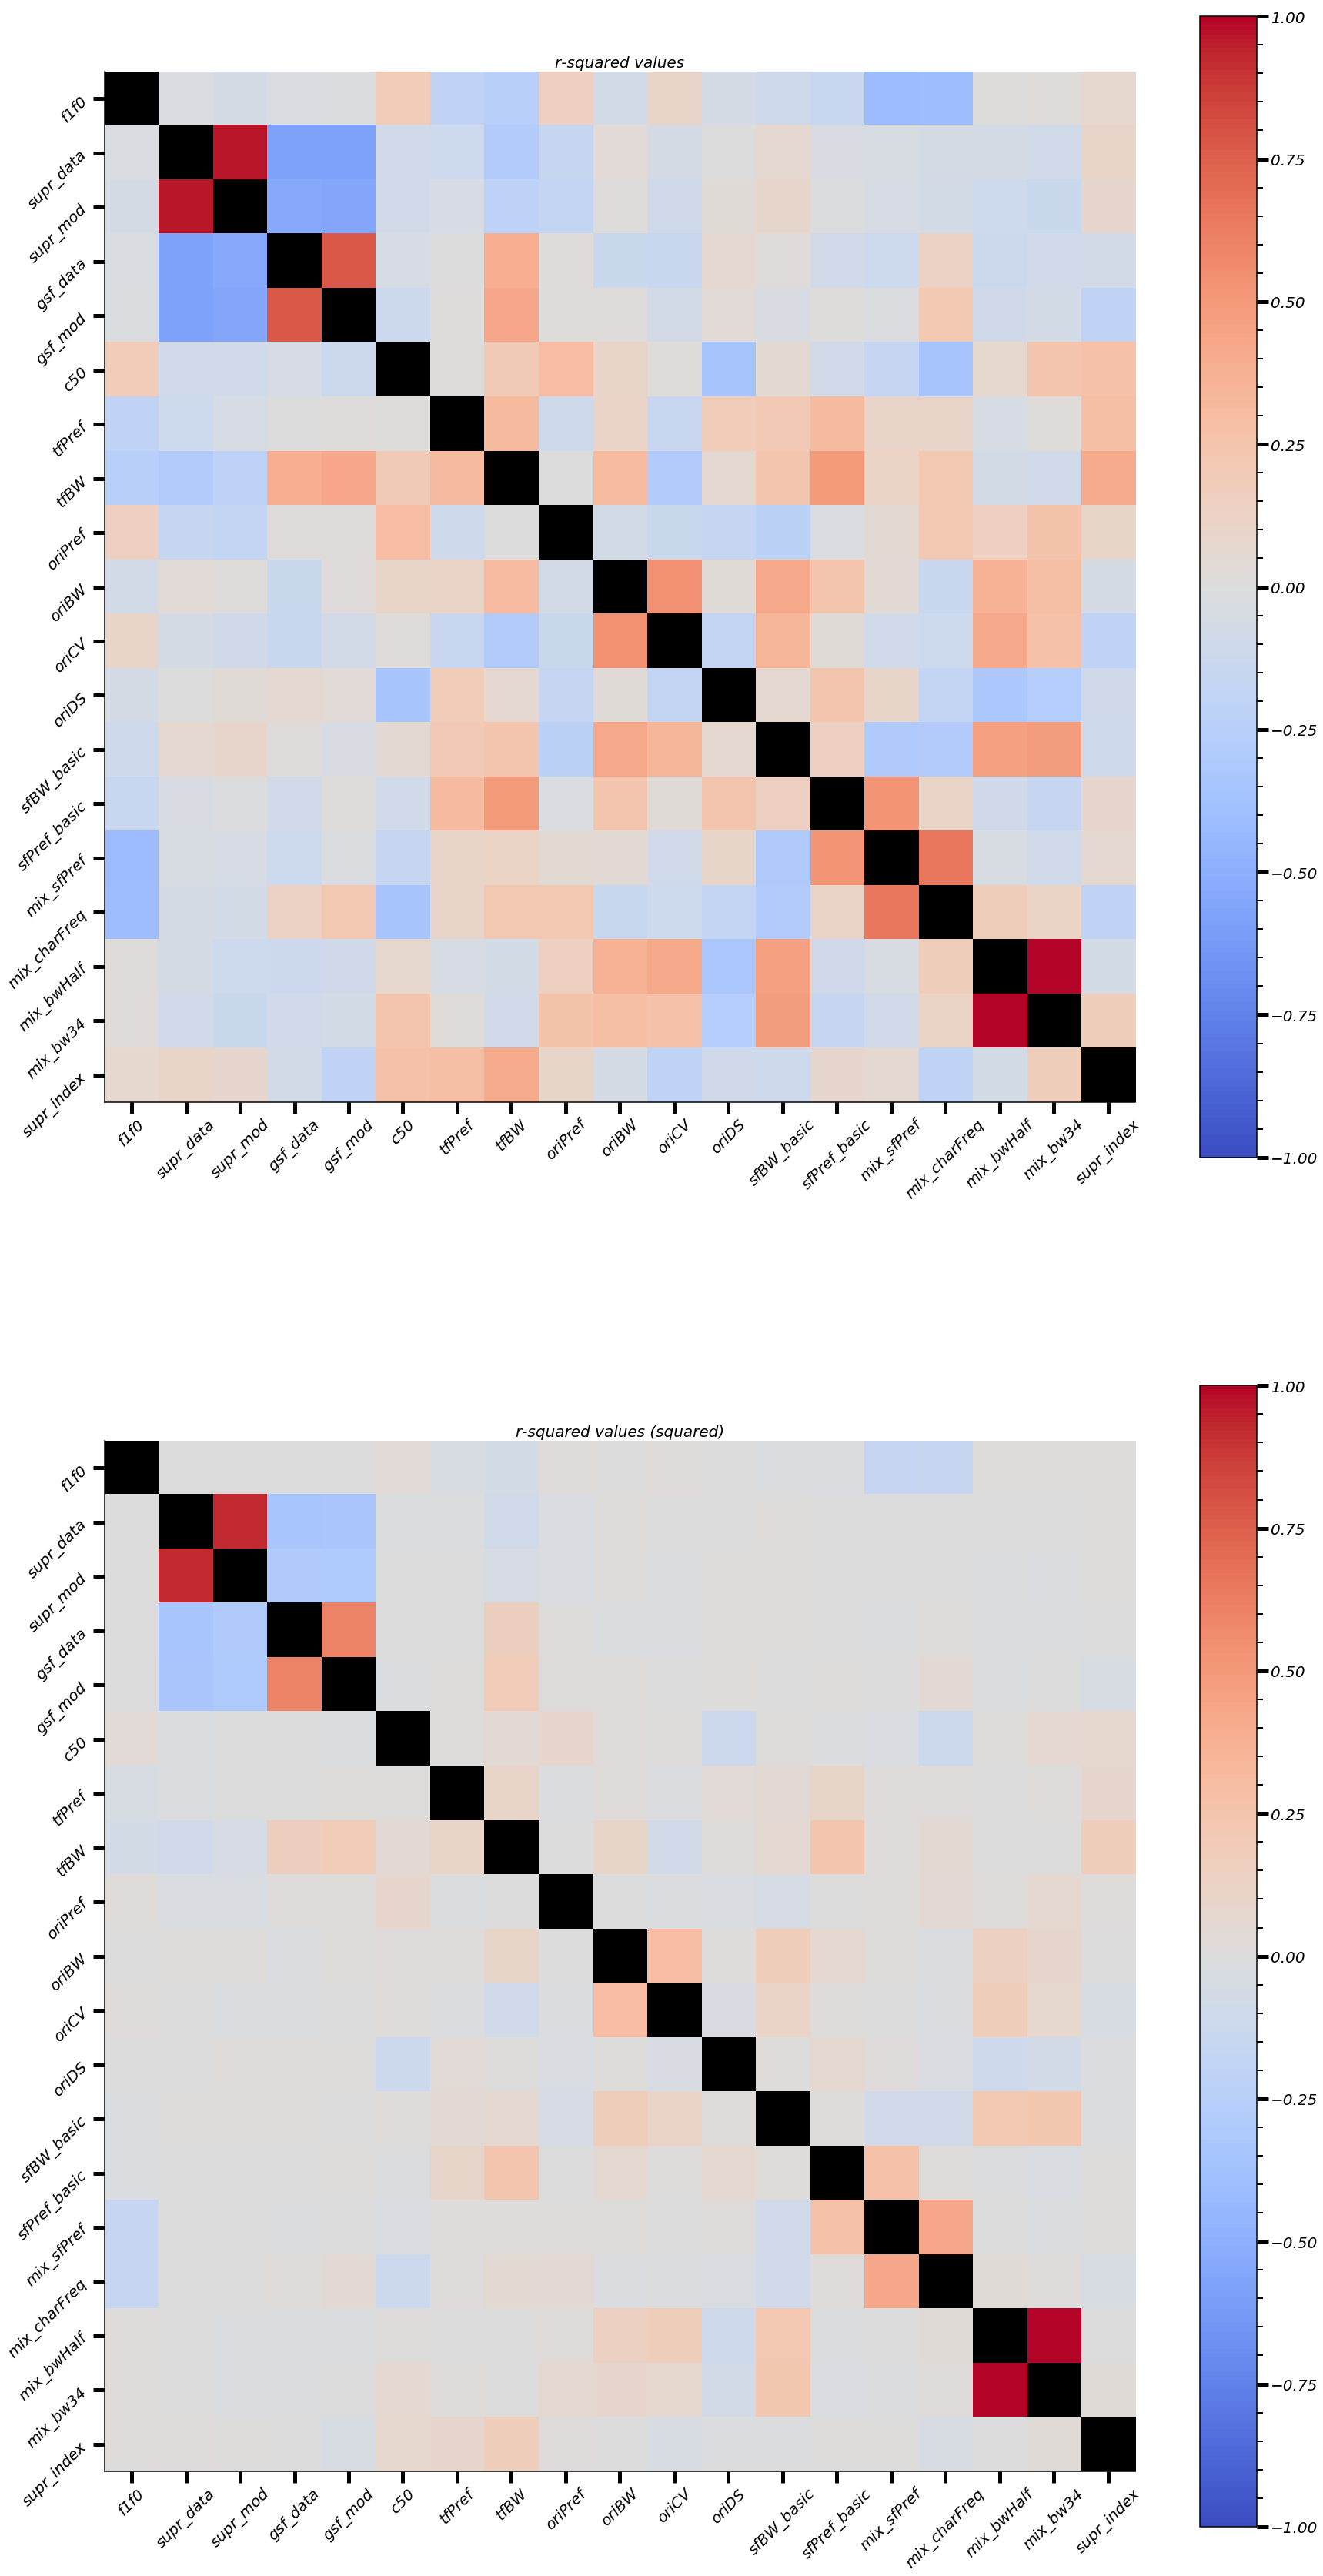

In [595]:
f, ax = plt.subplots(2, 1, figsize=(30, 2*30));

for i in range(2):
    plt.sca(ax[i])
    
    corrs = np.array(df.corr());
    xdiag, ydiag = np.diag_indices_from(corrs)
    corrs[xdiag, ydiag] = np.nan;
    cmp = cm.coolwarm;
    cmp.set_bad('black')
    if i == 1:
        im = ax[i].imshow(np.sign(corrs)*np.square(corrs), cmap=cmp, vmin=-1, vmax=1);
    else:
        im = ax[i].imshow(corrs, cmap=cmp, vmin=-1, vmax=1);
    plt.xticks(np.arange(len(all_ind_names)), all_ind_names, rotation=45);
    plt.yticks(np.arange(len(all_ind_names)), all_ind_names, rotation=45);
    plt.tick_params(axis='both', which='minor', left=False, bottom=False)
    f.colorbar(im, ax=ax[i]);
    if i == 0:
        ax[i].set_title('r-squared values')
    else:
        ax[i].set_title('r-squared values (squared)')


The top plot is the "raw" r-squared values; the bottom plot are the same values squared - but with sign preserved - to see more easily the larger magnitude values. 

First, there are the "obvious" correlations:
- **supr_mod w/ supr_data** (suppression index; the model is fit to the same data used to derive the data measure)
- **gsf_mod w/ gsf_data** (same as above)
- **supr w/ gsf**: if there is minimal suppression, gsf will be large; if suppression is strong, gsf will be small
- **mix_bwHalf/bw34**: same measure of SF tuning width, determined at half-height or 3/4 height
- **mix_charFreq/mix_sfPref**: both are measures of SF preference (one is peak, one is high-frequency cut-off)

Now, what should be investigated?:
- **f1/f0 w/ charFreq or sfPref** 
- **c50 w/charFreq** 
- **oriDS w/ sfBW**: 
- ****: 
- ****:

#### Then,  within the *de*pendent variables (i.e. response measures we want to explain)

In [602]:
df = pd.DataFrame(all_dep.transpose(), columns=all_dep_names)

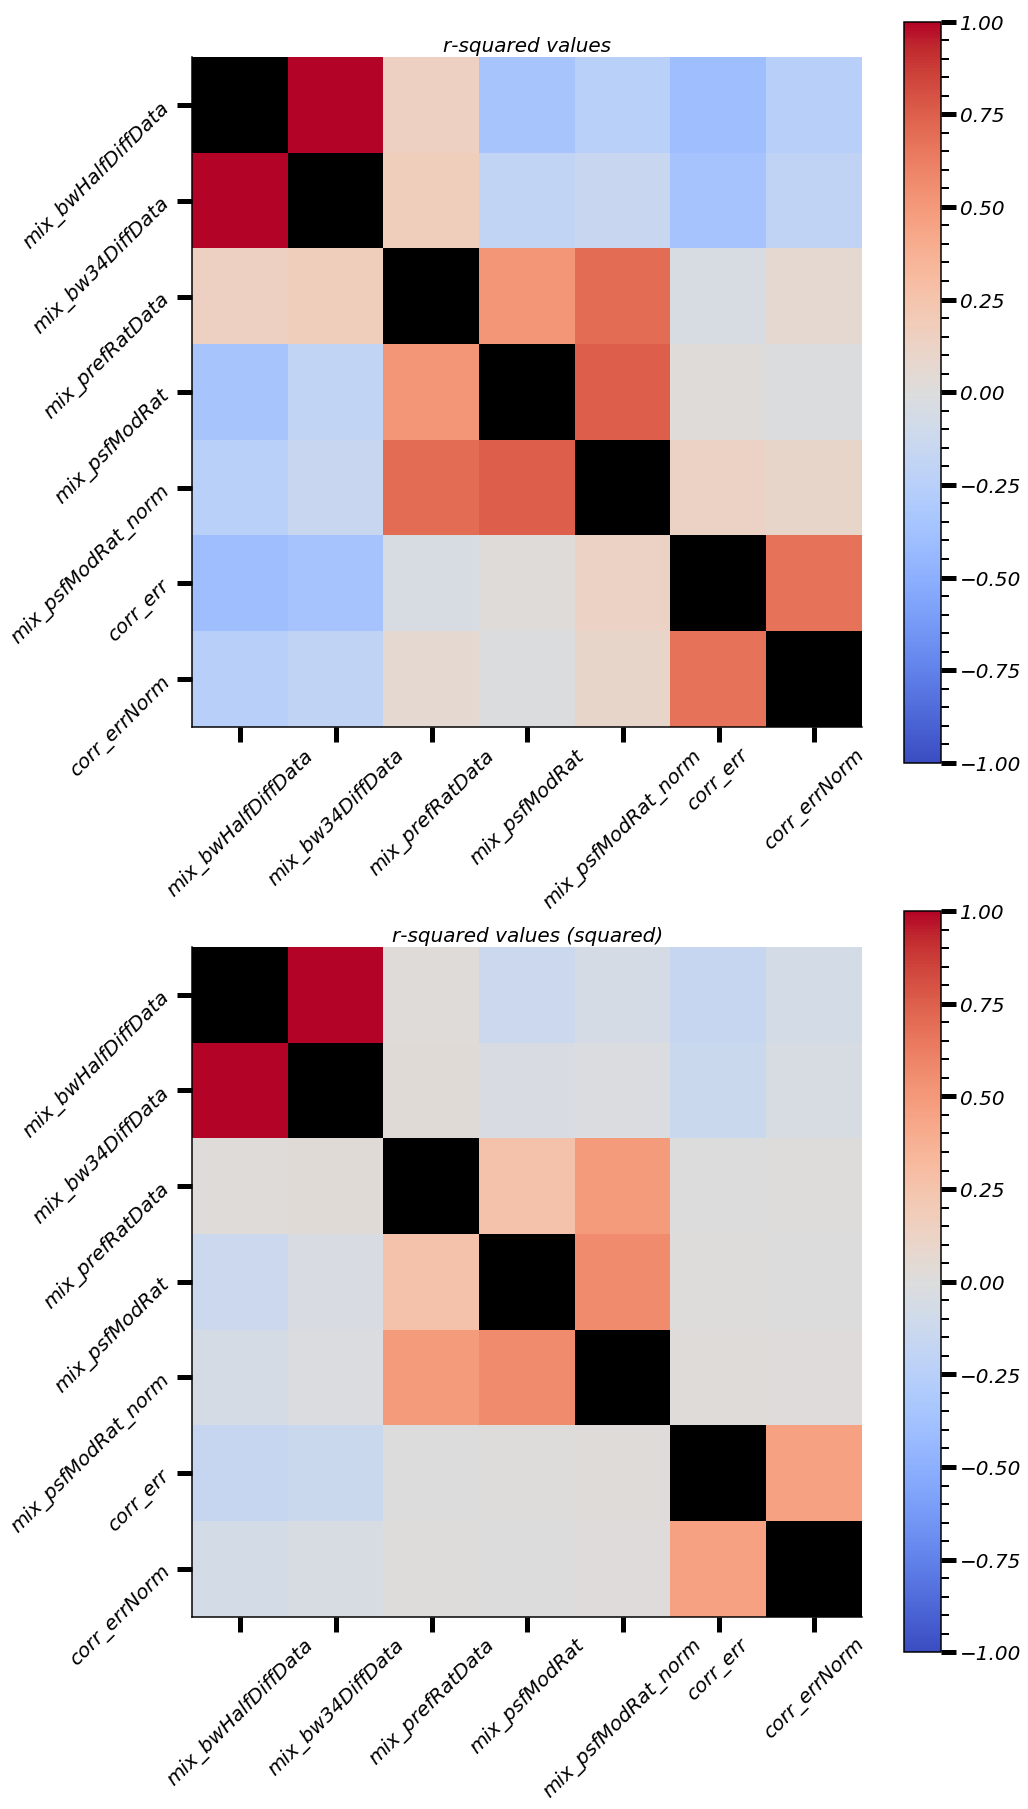

In [603]:
f, ax = plt.subplots(2, 1, figsize=(15, 2*15));

for i in range(2):
    plt.sca(ax[i])
    
    corrs = np.array(df.corr());
    xdiag, ydiag = np.diag_indices_from(corrs)
    corrs[xdiag, ydiag] = np.nan;
    cmp = cm.coolwarm;
    cmp.set_bad('black')
    if i == 1:
        im = ax[i].imshow(np.sign(corrs)*np.square(corrs), cmap=cmp, vmin=-1, vmax=1);
    else:
        im = ax[i].imshow(corrs, cmap=cmp, vmin=-1, vmax=1);
    plt.xticks(np.arange(len(all_dep_names)), all_dep_names, rotation=45);
    plt.yticks(np.arange(len(all_dep_names)), all_dep_names, rotation=45);
    plt.tick_params(axis='both', which='minor', left=False, bottom=False)
    f.colorbar(im, ax=ax[i]);
    if i == 0:
        ax[i].set_title('r-squared values')
    else:
        ax[i].set_title('r-squared values (squared)')


### First, one-by-one correlation
This should be subsumed by a multiple regression, but since there are too many NaN values in our independent variables (i.e. no prefSF ratio for one cell, no f1f0 ratio for another, etc) we end up having too few "complete" cells in the analysis.

In [496]:
n_deps = all_dep.shape[0];
n_inds = all_ind.shape[0];

all_reg_1d = dict();

for i_dep in np.arange(n_deps): # for each dependent variable
    for i_ind in np.arange(n_inds): # consider the correlation with each of the independent variables
        all_reg_1d[(i_dep, i_ind)] = dict();
        
        model = sm.OLS(endog=all_dep[i_dep, :], exog=sm.tools.add_constant(all_ind[i_ind, :]), missing='drop', hasconst=True).fit()
        
        # Print out the statistics
        all_reg_1d[(i_dep, i_ind)]['model'] = model;
        all_reg_1d[(i_dep, i_ind)]['n_cells'] = int(model.nobs)
        all_reg_1d[(i_dep, i_ind)]['rsquare'] = model.rsquared;
        all_reg_1d[(i_dep, i_ind)]['ind_name'] = all_ind_names[i_ind]
        all_reg_1d[(i_dep, i_ind)]['dep_name'] = all_dep_names[i_dep]
        all_reg_1d[(i_dep, i_ind)]['pval'] = model.pvalues[0]; # there's only one pvalue, here

In [497]:
all_keys = list(all_reg_1d)

In [498]:
r_vals = np.array([all_reg_1d[k]['rsquare'] for k in all_keys])
p_vals = np.array([all_reg_1d[k]['pval'] for k in all_keys])

In [499]:
lt_p05 = np.where(p_vals < 0.05)[0];
lt_keys = [all_keys[k] for k in lt_p05];

ind_lt05 = np.array([all_reg_1d[k]['ind_name'] for k in lt_keys])
unique_inds = np.unique(ind_lt05);
count_unique = np.array([np.sum(np.in1d(ind_lt05, k)) for k in unique_inds])
order_counts = np.argsort(count_unique)
ordered_names = unique_inds[order_counts];

print('Most *useful* dependent variables:')
['%s: %d' % (nm, ct) for nm,ct in zip(ordered_names, count_unique[order_counts])]

Most *useful* dependent variables:


['oriCV: 1',
 'mix_charFreq: 1',
 'tfBW: 1',
 'mix_bw34: 2',
 'mix_bwHalf: 2',
 'oriDS: 2',
 'oriPref: 2',
 'sfPref_basic: 3',
 'sfBW_basic: 3',
 'mix_sfPref: 3',
 'oriBW: 3',
 'tfPref: 4',
 'gsf_data: 5',
 'gsf_mod: 5',
 'f1f0: 5',
 'supr_data: 6',
 'supr_mod: 6']

In [500]:
dep_lt05 = np.array([all_reg_1d[k]['dep_name'] for k in lt_keys])
unique_inds = np.unique(dep_lt05);
count_unique = np.array([np.sum(np.in1d(dep_lt05, k)) for k in unique_inds])
order_counts = np.argsort(count_unique)
ordered_names = unique_inds[order_counts];

print('Most *explained* independent variables:')

['%s: %d' % (nm, ct) for nm,ct in zip(ordered_names, count_unique[order_counts])]

Most *explained* independent variables:


['mix_prefRatData: 2',
 'mix_psfModRat_norm: 3',
 'mix_psfModRat: 8',
 'corr_errNorm: 9',
 'mix_bw34DiffData: 10',
 'corr_err: 11',
 'mix_bwHalfDiffData: 11']

Plot the two variables below, and choose either the biggest "r" values or the smallest p-values

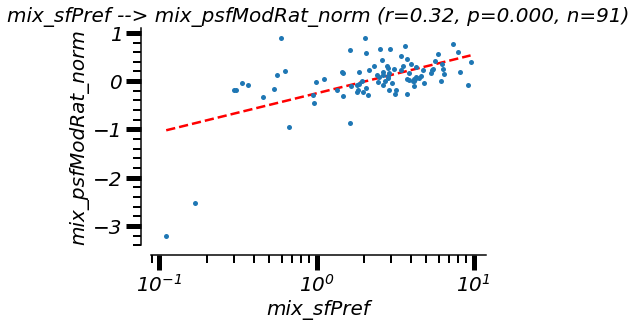

In [504]:
### Sort in terms of R-value
max_r = np.array(list(reversed(np.argsort(r_vals))))
r_ind = 3;
curr_key = all_keys[max_r[r_ind]];

### Sort in terms of P-value
# max_p = np.array(list(np.argsort(p_vals)))
# p_ind = 5;
# curr_key = all_keys[max_p[p_ind]];


curr_mod = all_reg_1d[curr_key];
r_val, p_val, n_cells = curr_mod['rsquare'], curr_mod['pval'], curr_mod['n_cells']
ind_name, dep_name = curr_mod['ind_name'], curr_mod['dep_name'];
title = '%s --> %s (r=%.2f, p=%.03f, n=%d)' % (ind_name, dep_name, r_val, p_val, n_cells)

x_vals = all_ind[curr_key[1], :];
y_vals = all_dep[curr_key[0], :];

val_inds = np.logical_and(~np.isnan(x_vals), ~np.isnan(y_vals));

to_eval = np.linspace(np.min(x_vals[val_inds]), np.max(x_vals[val_inds]), 100)
mod_eval = curr_mod['model'].predict(sm.tools.add_constant(to_eval))

if np.in1d(ind_name, all_ind_log_names):
    x_vals = np.power(2, x_vals);
    
    plt.xscale('log')
#     plt.xlim([np.round(np.nanmin(x_vals), decimals=1), np.round(np.nanmax(x_vals), decimals=0)])
    # plot the regression model
    plt.plot(np.power(2, to_eval), mod_eval, 'r--')
else:
    # plot the regression model
    plt.plot(to_eval, mod_eval, 'r--')

# plot the data
plt.plot(x_vals[val_inds], y_vals[val_inds], 'o', clip_on=False);
 
plt.xlabel('%s' % ind_name);
plt.ylabel('%s' % dep_name);
plt.title(title);
sns.despine(offset=10);

### Multiple regressors, one output
Having learned a bit from the one-to-one regression, let's try to put some of the more important/"useful" independent into one regression

In [505]:
ind_set = np.vstack((mix_sfPref, mix_bw34, supr_mod, f1f0, oriCV))

In [506]:
n_deps = all_dep.shape[0];
n_inds = ind_set.shape[0];

all_reg_nd = dict();

for i_dep in np.arange(n_deps): # consider the correlation with each of the independent variables
    all_reg_nd[i_dep] = dict();
    
    model = sm.OLS(endog=all_dep[i_dep, :], exog=sm.tools.add_constant(ind_set.transpose()), missing='drop', hasconst=True).fit()
    
    # Print out the statistics
    all_reg_nd[i_dep]['model'] = model;
    all_reg_nd[i_dep]['n_cells'] = int(model.nobs)
    all_reg_nd[i_dep]['rsquare'] = model.rsquared;
    all_reg_nd[i_dep]['ind_name'] = all_dep_names[i_dep]
    all_reg_nd[i_dep]['pval'] = model.pvalues; # there's only one pvalue, here
    

In [511]:
yr = pd.DataFrame(ind_set.transpose(), columns=('sfPref', 'bw34', 'supr_mod', 'f1f0', 'oriCV'));
yr.corr()

,sfPref,bw34,supr_mod,f1f0,oriCV
sfPref,1.000000,-0.093234,-0.055679,-0.408582,-0.081706
bw34,-0.093234,1.000000,-0.131302,0.016885,0.269827
supr_mod,-0.055679,-0.131302,1.000000,-0.046237,-0.074575
f1f0,-0.408582,0.016885,-0.046237,1.000000,0.102402
oriCV,-0.081706,0.269827,-0.074575,0.102402,1.000000


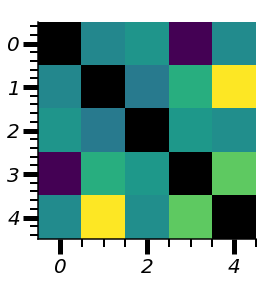

In [513]:
crs = np.array(yr.corr());
crs[np.diag_indices_from(crs)[0], np.diag_indices_from(crs)[1]] = np.nan;
plt.imshow(crs);

In [426]:
np.corrcoef(all_dep, )

array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan]])

In [425]:
all_reg_nd[0]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     5.600
Date:                Tue, 24 Mar 2020   Prob (F-statistic):           0.000260
Time:                        17:55:26   Log-Likelihood:                -42.732
No. Observations:                  67   AIC:                             97.46
Df Residuals:                      61   BIC:                             110.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5623      0.247     -2.274      0.026      -1.057      -0.068
x1             0.3059      0.072      4.255      0.000       0.162       0.450
x2             0.1440      0.090      1.601      0.114      -0.036       0.324
x3            -0.4607      0.194     -2.374      0.021      -0.849      -0.073
x4            -0.0133      0.050     -0.266      0.791      -0.114       0.087
x5             0.1515      0.255      0.593      0.555      -0.359       0.662
==============================================================================
Omnibus:                       13.675   Durbin-Watson:                   1.653
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               42.441
Skew:                          -0.342   Prob(JB):                     6.08e-10
Kurtosis:                       6.839   Cond. No.                         14.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [405]:
[all_reg_nd[x]['ind_name'] for x in np.arange(7)]

['mix_prefRatData',
 'mix_bwHalfDiffData',
 'mix_bw34DiffData',
 'mix_psfModRat',
 'mix_psfModRat_norm',
 'corr_err',
 'corr_errNorm']

In [406]:
[all_reg_nd[x]['pval'] for x in np.arange(7)]

[0.02647452683135783,
 0.02582839336537381,
 0.12283639714855608,
 0.2261020343267498,
 0.08858712764403508,
 0.20224219957715336,
 0.9003466889861826]

In [ ]:
curr_key = 0;

curr_mod = all_reg_nd[curr_key];
r_val, p_val, n_cells = curr_mod['rsquare'], curr_mod['pval'], curr_mod['n_cells']
dep_name = curr_mod['dep_name'];
title = ' --> %s (r=%.2f, p=%.03f, n=%d)' % (dep_name, r_val, p_val, n_cells)

x_vals = all_ind[curr_key[1], :];
y_vals = all_dep[curr_key[0], :];

val_inds = np.logical_and(~np.isnan(x_vals), ~np.isnan(y_vals));

to_eval = np.linspace(np.min(x_vals[val_inds]), np.max(x_vals[val_inds]), 100)
mod_eval = curr_mod['model'].predict(sm.tools.add_constant(to_eval))

if np.in1d(ind_name, all_ind_log_names):
    x_vals = np.power(2, x_vals);
    
    plt.xscale('log')
#     plt.xlim([np.round(np.nanmin(x_vals), decimals=1), np.round(np.nanmax(x_vals), decimals=0)])
    # plot the regression model
    plt.plot(np.power(2, to_eval), mod_eval, 'r--')
else:
    # plot the regression model
    plt.plot(to_eval, mod_eval, 'r--')

# plot the data
plt.plot(x_vals[val_inds], y_vals[val_inds], 'o', clip_on=False);
 
plt.xlabel('%s' % ind_name);
plt.ylabel('%s' % dep_name);
plt.title(title);
sns.despine(offset=10);

# STOP STOP STOP

Are you sure you want to run below this?

# Depricated/to-move
Note that the sections below are either obselete or will be (or have been) moved to other notebooks.

### plot pSf ratio against exc/norm filter ratio...

In [ ]:
# # the following is only for weighted normalization!
# sfRatToUse = psfModRats; # mod ratios or from-data ratios?

# c50_loc = 2;

# modParamRatio = lambda params: params[0]/np.power(10, params[-2]) if params != [] else np.nan; # it's second to last parameter
# modExcNormRat = [modParamRatio(jointList[x]['model']['params_wght']) for x in range(len(jointList))]
# getC50 = lambda params: params[c50_loc] if params != [] else np.nan; 
# c50s = np.array([getC50(jointList[x]['model']['params_wght']) for x in range(len(jointList))]);
# zTO1 = lambda x: np.divide(x - np.nanmin(x), np.nanmax(x - np.nanmin(x)));

In [ ]:
# np.argsort(modExcNormRat)

In [ ]:
# plt.semilogy(np.clip(modExcNormRat, np.power(10, -2.0), np.power(10, 2)), 'o');
# plt.xlabel('cell #');
# plt.ylabel('peak SF ratio: exc::norm');

In [ ]:
# val_inds = np.logical_and(~np.isnan(sfRatToUse), ~np.isnan(np.log2(modExcNormRat)));
# c50_color = cm.gray(zTO1(np.clip(c50s[val_inds], -2, 1)));
# plt.scatter(sfRatToUse[val_inds], np.clip(np.log2(np.array(modExcNormRat)[val_inds]), -2, 2), marker='o', color=c50_color);
# plt.xlabel('data contrast shift');
# plt.ylabel('model exc/norm ratio');

In [ ]:
# ### STATISTICAL TEST??
# nan_rm = lambda x: x[~np.isnan(x)]
# ttest_1samp(nan_rm(psfRats), 0)

Below this is older analyses - still good, but not my newest for VSS

In [ ]:
# height = 3/4; # measure BW at half-height
# sf_range = [0.01, 10]; # allowed values of 'mu' for fits - see descr_fit.py for details

In [ ]:
# ### sf tuning
# descrExp = hf.np_smart_load(data_loc + descrName)
# # HACKY: Just setting to descrFits on exp data...
# descrMod = hf.np_smart_load(data_loc + descrName)
# # descrMod = np.load(data_loc + descrModName, encoding='latin1').item()

# ### rvc
# rvcExp = hf.np_smart_load(data_loc + rvcName)
# # HACKY: Just setting to descrFits on exp data...
# rvcMod = hf.np_smart_load(data_loc + rvcName)

In [ ]:
# modParams = np.load(data_loc + fitName, encoding='latin1').item();

## Get bandwidth/prefSf measures organized

In [ ]:
# # get experiment parameters/organization
# nCells = len(jointList)

# maxComp = np.zeros((3,), dtype=int); # i.e.

# for f in dataList['unitName']:

#     cell = hf.np_smart_load(data_loc + f + '_sfm.npy');
#     expInd = hf.get_exp_ind(data_loc, f)[0];
#     _, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(cell, expInd);

#     for currComp, i in zip(stimVals, range(len(stimVals))):
#         if len(currComp) > maxComp[i]:
#             maxComp[i] = len(currComp);

# # now we know the maximum number of dispersions, sfs, and contrasts

In [ ]:
# nFamiliesMax, nConsMax, nSfsMax = maxComp;

# bwMod = np.zeros((nCells, nFamiliesMax, nConsMax)) * np.nan;
# bwExp = np.zeros((nCells, nFamiliesMax, nConsMax)) * np.nan;

# pSfMod = np.zeros((nCells, nFamiliesMax, nConsMax)) * np.nan;
# pSfExp = np.zeros((nCells, nFamiliesMax, nConsMax)) * np.nan;

# c50Mod = np.zeros((nCells, nFamiliesMax, nSfsMax)) * np.nan
# c50Exp = np.zeros((nCells, nFamiliesMax, nSfsMax)) * np.nan

In [ ]:
# for i in range(len(jointList)):

#     curr_cell = jointList[i]
    
#     for f in range(nFamiliesMax):
#         # spatial frequency stuff
#         for c in range(nConsMax):
        
#             try:
#                 # on data
#                 ignore, bwExp[i, f, c] = hf.compute_SF_BW(descrExp[i]['params'][f, c, :], height, sf_range)
#                 pSfExp[i, f, c] = descrExp[i]['params'][f, c, muLoc]
#             except: # then this dispersion does not have that contrast value, but it's ok - we already have nan
#                 pass 

#             try:
#                 # on model
#                 ignore, bwMod[i, f, c] = hf.compute_SF_BW(descrMod[i]['params'][f, c, :], height, sf_range)
#                 pSfMod[i, f, c] = descrMod[i]['params'][f, c, muLoc]
#             except: # then this dispersion does not have that contrast value, but it's ok - we already have nan
#                 pass

#         # RVC stuff
#         for s in range(nSfs):
#             if i in rvcExp:
#                 # on data
#                 try:
#                     c50Exp[i, f, s] = rvcExp[i]['params'][f, s, c50Loc];
#                 except: # then this dispersion does not have that SF value, but it's ok - we already have nan
#                     pass
                
#             if i in rvcMod:
#                 # on model
#                 try:
#                     c50Mod[i, f, s] = rvcMod[i]['params'][f, s, c50Loc];
#                 except: # then this dispersion does not have that SF value, but it's ok - we already have nan
#                     pass

In [ ]:
# bwModRats = np.zeros((nCells, nFamilies, nCons, nCons)) * np.nan;
# bwExpRats = np.zeros((nCells, nFamilies, nCons, nCons)) * np.nan;

# pSfModRats = np.zeros((nCells, nFamilies, nCons, nCons)) * np.nan;
# pSfExpRats = np.zeros((nCells, nFamilies, nCons, nCons)) * np.nan;

# c50ModRats = np.zeros((nCells, nFamilies, nSfs, nSfs)) * np.nan;
# c50ExpRats = np.zeros((nCells, nFamilies, nSfs, nSfs)) * np.nan;

In [ ]:
# for i in descrExp:
#     for f in range(nFamilies):
#         # as function of contrast
#         for comb in itertools.combinations(range(nCons), 2):
#             bwModRats[i,f,comb[0],comb[1]] = bwMod[i,f,comb[1]] - bwMod[i,f,comb[0]]
#             bwExpRats[i,f,comb[0],comb[1]] = bwExp[i,f,comb[1]] - bwExp[i,f,comb[0]]

#             pSfModRats[i,f,comb[0],comb[1]] = pSfMod[i,f,comb[1]] / pSfMod[i,f,comb[0]]
#             pSfExpRats[i,f,comb[0],comb[1]] = pSfExp[i,f,comb[1]] / pSfExp[i,f,comb[0]]

#         # as function of SF
#         for comb in itertools.permutations(range(nSfs), 2):
#             c50ModRats[i,f,comb[0],comb[1]] = c50Mod[i,f,comb[1]] / c50Mod[i,f,comb[0]]
#             c50ExpRats[i,f,comb[0],comb[1]] = c50Exp[i,f,comb[1]] / c50Exp[i,f,comb[0]]

### Organize model-derived ratio

Rather than taking just the data, we can restrict ourselves to well-fit (i.e. varExpl > a set threshold) tuning curves; read off the variable of interest (e.g. prefSf) for that curve, and fit a model to the progression of that variable with , e.g. contrast -- finally, read off the variable of interest from the model, rather than just the point/discrete values

In [ ]:
# ### Plot + compute pSfRatio in a model-derived way (i.e. use all prefSfs at different cons, fit a model and read off)
# # for individual cell

# varThresh = 80;
# cellNum = 4;
# disp = 0;

# name = dataList['unitName'][cellNum-1];
# expInd = hf.get_exp_ind(data_loc, name)[0];
# cell = hf.np_smart_load(data_loc + name + '_sfm.npy')
# _, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(cell, expInd);
# all_cons = stimVals[1];
# nFamilies = len(stimVals[0]);


# pSfRatio, psf_model, opt_params = hf.dog_prefSfMod(descrExp[cellNum-1], allCons=all_con, disp=disp, varThresh=varThresh, dog_model=0)

# valInds = np.where(descrExp[cellNum-1]['varExpl'][disp, :] > varThresh)[0];
# logConRat = np.log2(all_con[valInds[-1]]/all_con[valInds[0]]);
# plt.plot(all_con, psf_model(*opt_params, con=all_con))
# plt.plot(all_con[valInds], pSfExp[cellNum-1, disp, valInds], 'o')
# plt.title('Ratio at extremes: %.2f, or %.2f per log(2) contrast step' % (pSfRatio, pSfRatio/logConRat));

In [ ]:
# ### Compute pSfRatio in a model-derived way (i.e. use all prefSfs at different cons, fit a model and read off)

# varThresh = 80;
# pSfDerivRats = np.zeros((nCells, nFamilies, 2)) * np.nan

# for f, ind in zip(dataList['unitName'], range(nCells)):
    
#     expInd = hf.get_exp_ind(data_loc, f)[0];
#     cell = hf.np_smart_load(data_loc + f + '_sfm.npy')
#     _, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(cell, expInd);
#     all_cons = stimVals[1];
#     nFamilies = len(stimVals[0]);
    
#     for disp in range(nFamilies):

#         try:
#             pSfRatio, psf_model, opt_params = hf.dog_prefSfMod(descrExp[ind], allCons=all_con, disp=disp, varThresh=varThresh, dog_model=0)

#             valInds = np.where(descrExp[ind]['varExpl'][disp, :] > varThresh)[0];
#             logConRat = np.log2(all_con[valInds[-1]]/all_con[valInds[0]]);

#             pSfDerivRats[ind, disp, :] = [pSfRatio, np.log2(pSfRatio)/logConRat]
#         except:
#             pass # then either fit doesn't exist or no SF descr fits passed thresh; we've already initialized to nan

In [ ]:
# f, ax = plt.subplots(2, nFamiliesMax, figsize=(10*nFamiliesMax, 12));

# binsRat = np.linspace(-4,4,9)
# binsUnit = np.linspace(-4,4,9)

# for i in range(nFamiliesMax):

#     nonNan = np.where(~np.isnan(pSfDerivRats[:, i, 0]))
#     ax[0, i].hist(np.clip(np.log2(pSfDerivRats[nonNan, i, 0][0]), binsRat[0], binsRat[-1]), bins=binsRat, rwidth=0.9)
#     if i == 0:
#         ax[0, i].set_xlabel('Ratio of prefSf at highest to lowest contrast')
    
#     ax[1, i].hist(np.clip(pSfDerivRats[nonNan, i, 1][0], binsUnit[0], binsUnit[-1]), bins=binsUnit, rwidth=0.9)
#     if i == 0:
#         ax[1, i].set_xlabel(r'log $\Delta$ prefSf per unit log contrast')

# sns.despine(offset=10)

### Ratio plots as matricies (i.e. all relevant pairwise ratios)

Now, we compute all pairwise combinations so that we can compute the ratios/differences of these measures.
- For the pSf/BW, which we measure at distinct contrasts, we want to take the ratio as relative to the higher contrast, which is the larger index into all_cons
- For the c50 measure, this is a function of SF; we'll eventually want to take the ratios relative to the preferred (or closest-to-preferred) SF

In [ ]:
# pSfExp.shape

In [ ]:
# pSfExp[ind, 0, -1]

### now, example "upper diag plots"

In [ ]:

# cellNum = 17;
# dispInd = 0;

# cell = hf.np_smart_load(data_loc + dataList['unitName'][cellNum-1] + '_sfm.npy');
# expInd = hf.get_exp_ind(data_loc, dataList['unitName'][cellNum-1])[0];
# _, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(cell, expInd);
# all_disp, all_con, all_sf = stimVals;

# metrics = [bwExpRats, pSfExpRats, c50ExpRats];
# metricNames = ['bandwidth difference (oct)', 'prefSf ratio', 'c50 ratio'];
# metricUnits = ['(con %)', '(con %)', '(sf cpd)']
# metricScales = [all_con, all_con, all_sf];
# metricLog    = [0, 1, 1]; # do not log bw diff, but log other measures
# metricRef    = [0, 1, 1]; # what is the reference value
# nPlots = len(metrics);

# f, ax = plt.subplots(2, nPlots, figsize=(15*nPlots, 2*12))

# for m, mn, ms, mu, ml, mr, ind in zip(metrics, metricNames, metricScales, metricUnits, metricLog, metricRef, range(nPlots)):

#     ### First, the overall summaries
#     if ml == 1:
#         imCurr = ax[0, ind].imshow(np.log2(m[cellNum-1, dispInd, :, :]));
#     elif ml == 0:
#         imCurr = ax[0, ind].imshow(m[cellNum-1, dispInd, :, :]);
#     ax[0, ind].set_xlabel('reference %s' % mu)
#     ax[0, ind].set_ylabel('test')
#     # find out which are valid indices
#     valids = np.where(np.any(~np.isnan(m[cellNum-1, dispInd, :, :]), 0))[0]
#     ax[0, ind].xaxis.set_ticks(valids)
#     ax[0, ind].yaxis.set_ticks(valids)
#     ax[0, ind].xaxis.set_ticklabels(['%.2f' % x for x in ms[valids]], rotation='30')
#     ax[0, ind].yaxis.set_ticklabels(['%.2f' % x for x in ms[valids]], rotation='30')
#     f.colorbar(imCurr, ax=ax[0, ind]);
#     ax[0, ind].set_title('%s' % mn);
    
#     ### Then, the ratio plots for the "preferred" case (i.e. highest con, peakSf)
#     # all of the plots here should be w.r.t. log(x)
#     if np.all(ms == all_sf): # find peak SF...
#         peakSf = pSfExp[ind, dispInd, val_con_by_disp[dispInd][-1]]; # i.e. highest contrast
#         peakInd = np.argmin(np.square(ms[valids] - peakSf));
#         peakInd = valids[peakInd];
#     else:
#         peakInd = valids[-1]; # i.e. the highest contrast
#     if ml == 1:
#         ax[1, ind].loglog(ms[valids], m[cellNum-1, dispInd, valids, peakInd], 'o-')
#     elif ml == 0:
#         ax[1, ind].semilogx(ms[valids], m[cellNum-1, dispInd, valids, peakInd], 'o-')
#     # set the reference line
#     ax[1, ind].axhline(mr, linestyle='--')
#     # set the axes...
#     ax[1, ind].xaxis.set_ticks(ms[valids])
#     ax[1, ind].xaxis.set_ticklabels(['%.2f' % x for x in ms[valids]], rotation='30')
#     # labels
#     ax[1, ind].set_xlabel('test (ref: %.2f) %s' % (ms[peakInd], mu))
#     ax[1, ind].set_ylabel('%s (ref:test)' % mn)
    
# f.suptitle('Changes with contrast: cell %d, dispersion %d' % (cellInd, dispInd));

In [ ]:
# from the old way...
# bwDiffMod = bwMod[:, :, conInd[1]] - bwMod[:,:, conInd[0]]
# bwDiffExp = bwExp[:, :, conInd[1]] - bwExp[:,:, conInd[0]]

# pSfRatioMod = pSfMod[:, :, conInd[1]] / pSfMod[:,:, conInd[0]]
# pSfRatioExp = pSfExp[:, :, conInd[1]] / pSfExp[:,:, conInd[0]]